<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Markdown" data-toc-modified-id="Markdown-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Markdown</a></span><ul class="toc-item"><li><span><a href="#Restrict-notebooks" data-toc-modified-id="Restrict-notebooks-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Restrict notebooks</a></span></li></ul></li><li><span><a href="#Notebooks" data-toc-modified-id="Notebooks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Notebooks</a></span></li><li><span><a href="#Language" data-toc-modified-id="Language-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Language</a></span><ul class="toc-item"><li><span><a href="#Main-language" data-toc-modified-id="Main-language-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Main language</a></span></li><li><span><a href="#Languages" data-toc-modified-id="Languages-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Languages</a></span></li><li><span><a href="#Compare-to-english" data-toc-modified-id="Compare-to-english-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Compare to english</a></span><ul class="toc-item"><li><span><a href="#English-only" data-toc-modified-id="English-only-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>English only</a></span></li><li><span><a href="#French-notebooks" data-toc-modified-id="French-notebooks-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>French notebooks</a></span></li><li><span><a href="#Danish-notebooks" data-toc-modified-id="Danish-notebooks-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Danish notebooks</a></span></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Comparison</a></span></li><li><span><a href="#Notebooks-with-english-markdown" data-toc-modified-id="Notebooks-with-english-markdown-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>Notebooks with english markdown</a></span></li><li><span><a href="#Notebooks-with-other-languages" data-toc-modified-id="Notebooks-with-other-languages-3.3.6"><span class="toc-item-num">3.3.6&nbsp;&nbsp;</span>Notebooks with other languages</a></span></li><li><span><a href="#Notebooks-with-undetected-cells" data-toc-modified-id="Notebooks-with-undetected-cells-3.3.7"><span class="toc-item-num">3.3.7&nbsp;&nbsp;</span>Notebooks with undetected cells</a></span></li><li><span><a href="#Venn" data-toc-modified-id="Venn-3.3.8"><span class="toc-item-num">3.3.8&nbsp;&nbsp;</span>Venn</a></span></li></ul></li></ul></li><li><span><a href="#Notebook-Size" data-toc-modified-id="Notebook-Size-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Notebook Size</a></span></li><li><span><a href="#Elements" data-toc-modified-id="Elements-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Elements</a></span></li><li><span><a href="#Header-size" data-toc-modified-id="Header-size-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Header size</a></span></li><li><span><a href="#P-size" data-toc-modified-id="P-size-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>P size</a></span></li></ul></div>

# Markdown

Analyze Markdown: language, lines, words, elements.

In [1]:
import sys

sys.path.insert(0, "../archaeology")
sys.path.insert(0, "../analysis")
import importlib
from collections import Counter

import numpy as np
import pandas as pd
from db import connect
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

import analysis_helpers

importlib.reload(analysis_helpers)
from analysis_helpers import (calculate_auto, close_fig, count, counter_hist,
                              display_counts, distribution_with_boxplot,
                              relative_var, var)

%matplotlib inline

In [2]:
%%time
with connect() as session:
    # print('Last query:', session.query(Query).all()[-1])
    raw_notebooks = pd.read_sql_table("notebook_markdowns", session.connection())
    print("Notebook Markdowns:", len(raw_notebooks))

Notebook Markdowns: 27187
CPU times: user 5.48 s, sys: 110 ms, total: 5.59 s
Wall time: 5.71 s


## Restrict notebooks

In [3]:
SKIP_MAP = {
    "f_": 1024 + 512,
    "d_": 1024 + 512 + 128,
    "dt_": 1024 + 512 + 128 + 32,
    "dr_": 1024 + 512 + 128 + 64,
}

CONFIG = {
    "Default": "f_",
    "Remove duplicates": "d_",
    "Remove duplicates and toy": "dt_",
    "Remove duplicates and restricted toy": "dr_",
}

In [4]:
@calculate_auto(CONFIG, save_to="notebooks", level=None)
def func(prefix=""):
    return raw_notebooks[
        np.bitwise_and(raw_notebooks["skip"], SKIP_MAP[prefix]) == 0
    ].copy()

In [5]:
@calculate_auto(CONFIG, save_to="total_notebooks", result=None, level=None)
def fn(prefix):
    with connect() as session:
        query = (
            "SELECT count(id) "
            "FROM notebooks "
            "WHERE NOT (kernel = 'no-kernel' AND nbformat = '0') "
            "AND total_cells != 0 "
            "AND skip & {} = 0"
        ).format(SKIP_MAP[prefix])

        result = session.execute(query)
        total_notebooks = result.scalar()
        return total_notebooks

In [6]:
@calculate_auto(CONFIG, save_to="with_markdown", result=None, level=None)
def fn(notebooks, prefix):
    with_markdown = notebooks[notebooks["cell_count"] > 0]
    return with_markdown


@calculate_auto(CONFIG, save_to="total_with_markdown", result=None)
def fn(with_markdown, total_notebooks, prefix):
    total_with_markdown = len(with_markdown)
    print(
        relative_var(
            prefix + "notebooks_with_markdown", len(with_markdown), total_notebooks
        )
    )
    return total_with_markdown

### Default

22,733 (83.58%)


### Remove duplicates

22,733 (83.58%)


### Remove duplicates and toy

22,733 (83.58%)


### Remove duplicates and restricted toy

22,733 (83.58%)


In [7]:
@calculate_auto(CONFIG)
def fn(total_notebooks, with_markdown, prefix):
    return relative_var(
        prefix + "no_markdown_cells",
        total_notebooks - len(with_markdown),
        total_notebooks,
    )

### Default

4,467 (16.42%)


### Remove duplicates

4,467 (16.42%)


### Remove duplicates and toy

4,467 (16.42%)


### Remove duplicates and restricted toy

4,467 (16.42%)


# Notebooks

In [8]:
@calculate_auto(CONFIG, save_to="notebooks", result=None, level=None)
def fn(with_markdown, prefix):
    display(with_markdown.head(5))
    return with_markdown

,id,repository_id,notebook_id,cell_count,main_language,languages,languages_counts,using_stopwords,len,lines,...,block_math_len,block_math_lines,block_math_words,block_math_stopwords,latex,latex_len,latex_lines,latex_words,latex_stopwords,skip
0,1,3,1,24,english,english,24,24,5350,66,...,0,0,0,0,0,0,0,0,0,0
1,2,6,2,35,english,"english,undetected","34,1",34,10593,95,...,0,0,0,0,0,0,0,0,0,0
2,3,8,3,13,english,english,13,13,6956,54,...,0,0,0,0,0,0,0,0,0,0
3,4,8,4,8,english,english,8,8,3319,41,...,0,0,0,0,0,0,0,0,0,0
4,5,8,5,14,english,"english,french","13,1",14,6844,53,...,0,0,0,0,0,0,0,0,0,0


,id,repository_id,notebook_id,cell_count,main_language,languages,languages_counts,using_stopwords,len,lines,...,block_math_len,block_math_lines,block_math_words,block_math_stopwords,latex,latex_len,latex_lines,latex_words,latex_stopwords,skip
0,1,3,1,24,english,english,24,24,5350,66,...,0,0,0,0,0,0,0,0,0,0
1,2,6,2,35,english,"english,undetected","34,1",34,10593,95,...,0,0,0,0,0,0,0,0,0,0
2,3,8,3,13,english,english,13,13,6956,54,...,0,0,0,0,0,0,0,0,0,0
3,4,8,4,8,english,english,8,8,3319,41,...,0,0,0,0,0,0,0,0,0,0
4,5,8,5,14,english,"english,french","13,1",14,6844,53,...,0,0,0,0,0,0,0,0,0,0


,id,repository_id,notebook_id,cell_count,main_language,languages,languages_counts,using_stopwords,len,lines,...,block_math_len,block_math_lines,block_math_words,block_math_stopwords,latex,latex_len,latex_lines,latex_words,latex_stopwords,skip
0,1,3,1,24,english,english,24,24,5350,66,...,0,0,0,0,0,0,0,0,0,0
1,2,6,2,35,english,"english,undetected","34,1",34,10593,95,...,0,0,0,0,0,0,0,0,0,0
2,3,8,3,13,english,english,13,13,6956,54,...,0,0,0,0,0,0,0,0,0,0
3,4,8,4,8,english,english,8,8,3319,41,...,0,0,0,0,0,0,0,0,0,0
4,5,8,5,14,english,"english,french","13,1",14,6844,53,...,0,0,0,0,0,0,0,0,0,0


,id,repository_id,notebook_id,cell_count,main_language,languages,languages_counts,using_stopwords,len,lines,...,block_math_len,block_math_lines,block_math_words,block_math_stopwords,latex,latex_len,latex_lines,latex_words,latex_stopwords,skip
0,1,3,1,24,english,english,24,24,5350,66,...,0,0,0,0,0,0,0,0,0,0
1,2,6,2,35,english,"english,undetected","34,1",34,10593,95,...,0,0,0,0,0,0,0,0,0,0
2,3,8,3,13,english,english,13,13,6956,54,...,0,0,0,0,0,0,0,0,0,0
3,4,8,4,8,english,english,8,8,3319,41,...,0,0,0,0,0,0,0,0,0,0
4,5,8,5,14,english,"english,french","13,1",14,6844,53,...,0,0,0,0,0,0,0,0,0,0


# Language

## Main language

### Default

,0
english,19484
undetected,1932
italian,341
indonesian,253
french,221
german,145
romanian,101
portuguese,56
spanish,50
norwegian,46


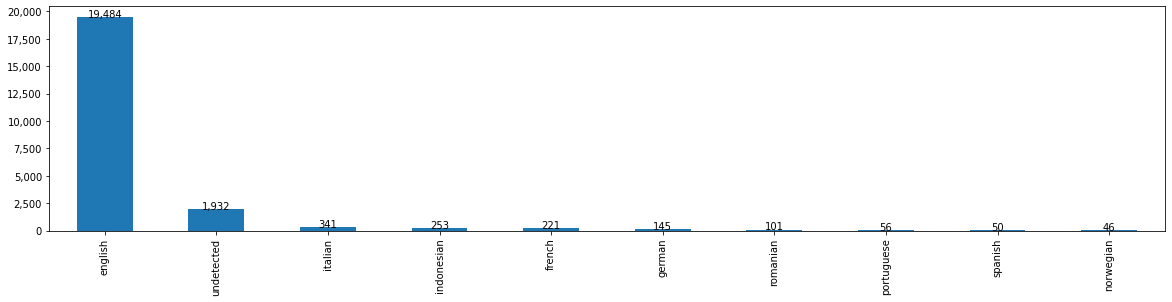

### Remove duplicates

,0
english,19484
undetected,1932
italian,341
indonesian,253
french,221
german,145
romanian,101
portuguese,56
spanish,50
norwegian,46


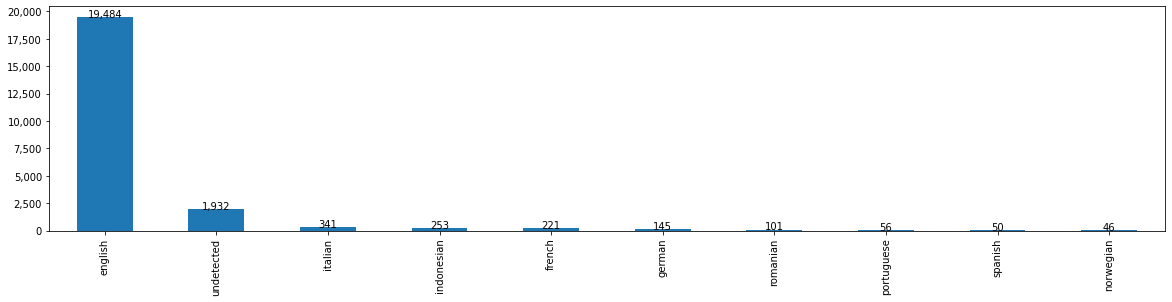

### Remove duplicates and toy

,0
english,19484
undetected,1932
italian,341
indonesian,253
french,221
german,145
romanian,101
portuguese,56
spanish,50
norwegian,46


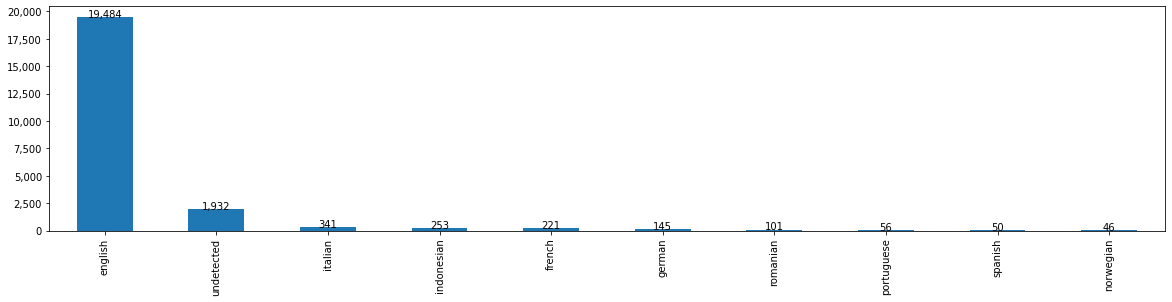

### Remove duplicates and restricted toy

,0
english,19484
undetected,1932
italian,341
indonesian,253
french,221
german,145
romanian,101
portuguese,56
spanish,50
norwegian,46


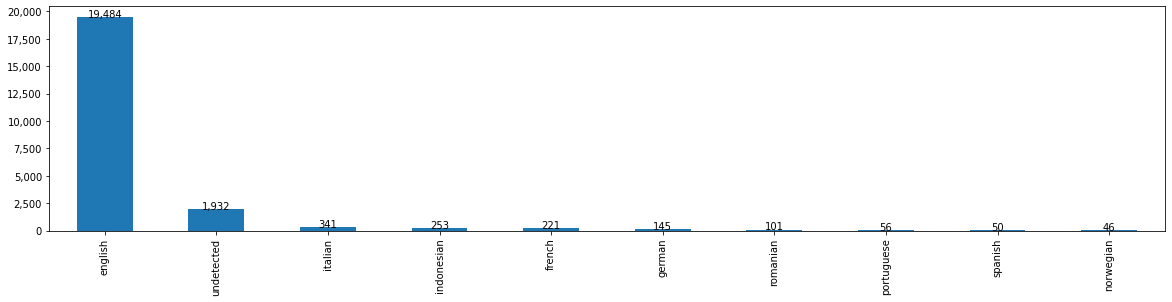

In [9]:
@calculate_auto(CONFIG)
@close_fig
def fn(notebooks, prefix):
    counter = Counter()
    notebooks["main_language"].agg(
        lambda x: counter.update({y for y in x.split(",") if y})
    )
    del counter[""]
    counts = pd.Series(counter).sort_values(ascending=False)
    # with savefig(prefix + "notebook_feature_run_line_magic", 9, 4):
    fig, cnt = display_counts(
        counts, width=20, show_values=True, plot=False, cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)

## Languages

### Default

,0
english,21903
undetected,8660
italian,4721
romanian,3317
french,3204
indonesian,3025
german,2468
norwegian,1584
swedish,1505
danish,1320


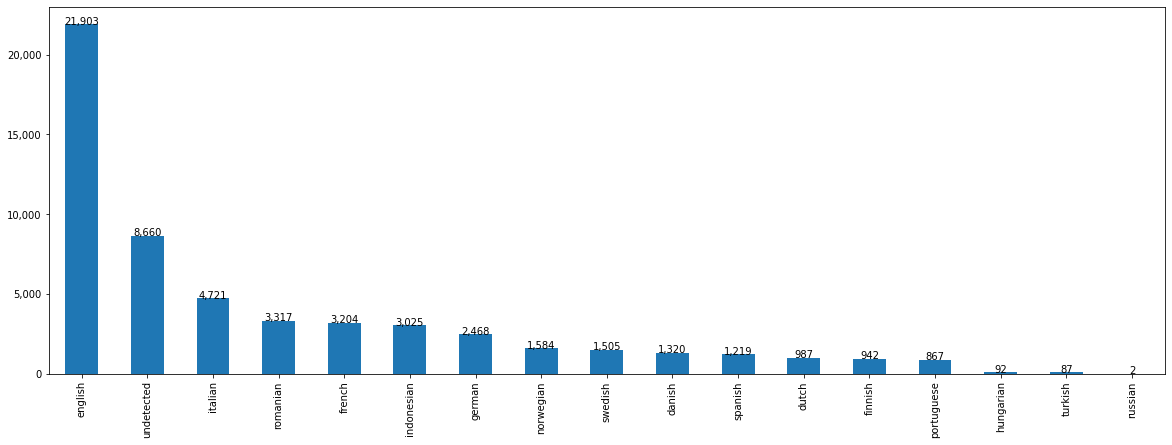

### Remove duplicates

,0
english,21903
undetected,8660
italian,4721
romanian,3317
french,3204
indonesian,3025
german,2468
norwegian,1584
swedish,1505
danish,1320


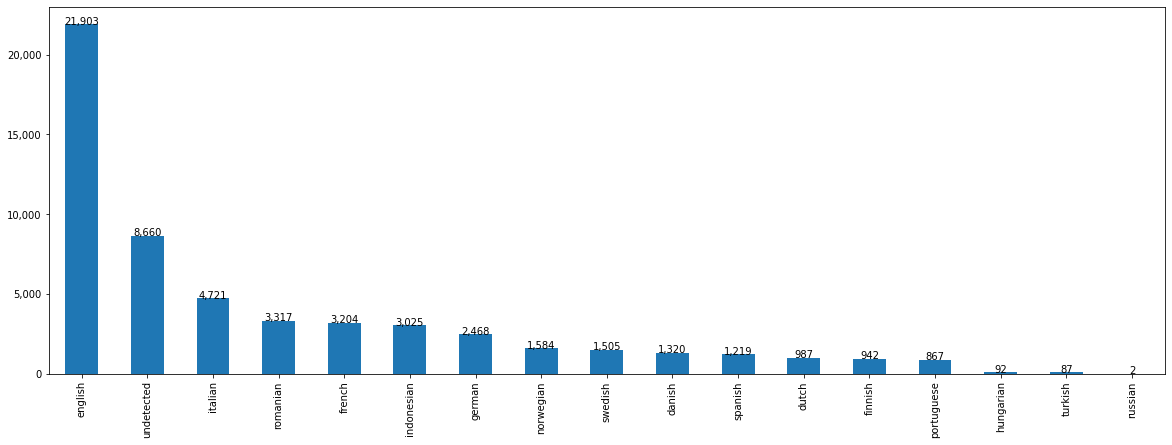

### Remove duplicates and toy

,0
english,21903
undetected,8660
italian,4721
romanian,3317
french,3204
indonesian,3025
german,2468
norwegian,1584
swedish,1505
danish,1320


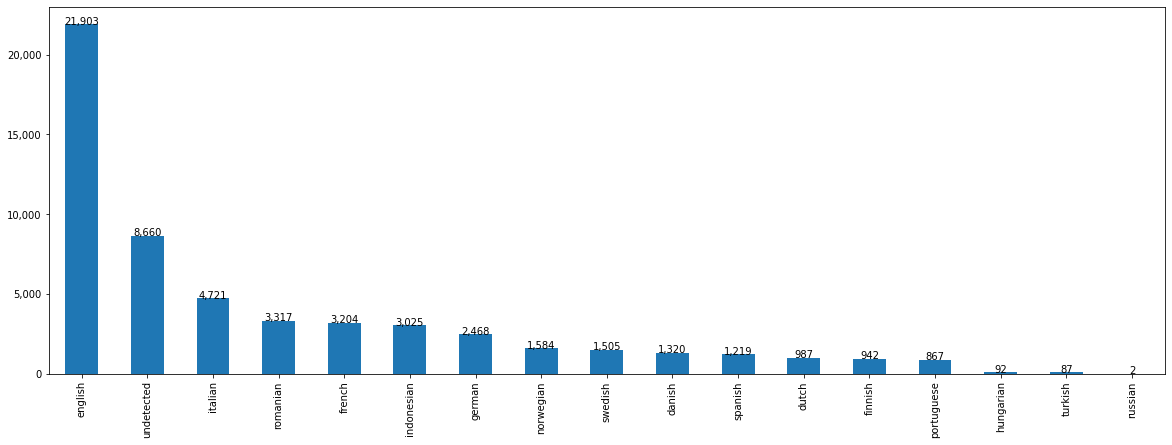

### Remove duplicates and restricted toy

,0
english,21903
undetected,8660
italian,4721
romanian,3317
french,3204
indonesian,3025
german,2468
norwegian,1584
swedish,1505
danish,1320


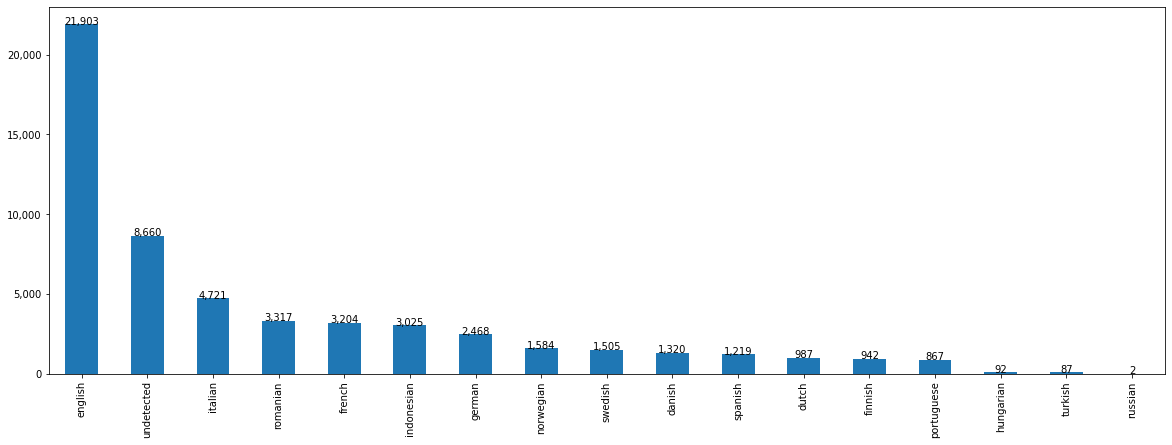

In [10]:
@calculate_auto(CONFIG, save_to="cnt", result=None)
@close_fig
def fn(notebooks, prefix):
    counter = Counter()
    notebooks["languages"].agg(lambda x: counter.update({y for y in x.split(",") if y}))
    del counter[""]
    counts = pd.Series(counter).sort_values(ascending=False)
    # with savefig(prefix + "notebook_feature_run_line_magic", 9, 4):
    fig, cnt = display_counts(
        counts, width=20, show_values=True, plot=False, cut=slice(None, 20), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)
    return cnt

## Compare to english

### English only

In [11]:
@calculate_auto(CONFIG)
def fn(notebooks, total_with_markdown, prefix):
    return relative_var(
        prefix + "notebooks_with_english_only_markdown",
        len(notebooks[notebooks["languages"] == "english"]),
        total_with_markdown,
    )

### Default

8,359 (36.77%)


### Remove duplicates

8,359 (36.77%)


### Remove duplicates and toy

8,359 (36.77%)


### Remove duplicates and restricted toy

8,359 (36.77%)


### French notebooks

In [12]:
@calculate_auto(CONFIG)
def fn(cnt, total_with_markdown, prefix):
    return relative_var(
        prefix + "notebooks_with_french_markdown",
        cnt.loc["french", 0],
        total_with_markdown,
    )

### Default

3,204 (14.09%)


### Remove duplicates

3,204 (14.09%)


### Remove duplicates and toy

3,204 (14.09%)


### Remove duplicates and restricted toy

3,204 (14.09%)


### Danish notebooks

In [13]:
@calculate_auto(CONFIG)
def fn(cnt, total_with_markdown, prefix):
    return relative_var(
        prefix + "notebooks_with_danish_markdown",
        cnt.loc["danish", 0],
        total_with_markdown,
    )

### Default

1,320 (5.81%)


### Remove duplicates

1,320 (5.81%)


### Remove duplicates and toy

1,320 (5.81%)


### Remove duplicates and restricted toy

1,320 (5.81%)


### Comparison

### Default

,0
english,21903
other,11921
undetected,8660


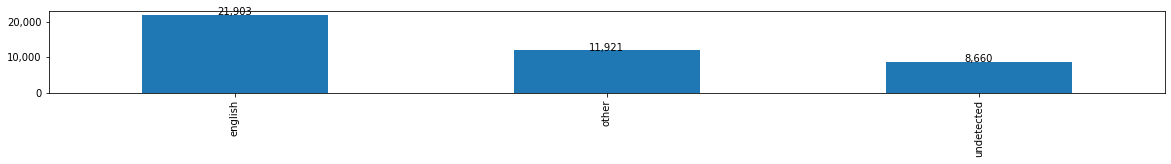

### Remove duplicates

,0
english,21903
other,11921
undetected,8660


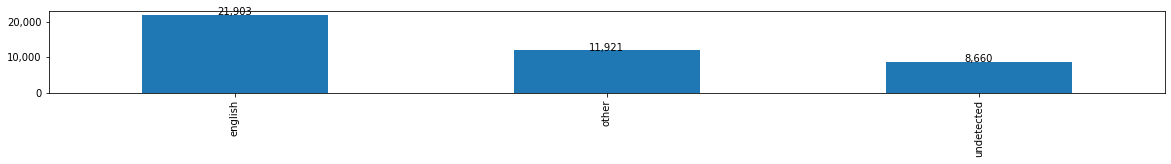

### Remove duplicates and toy

,0
english,21903
other,11921
undetected,8660


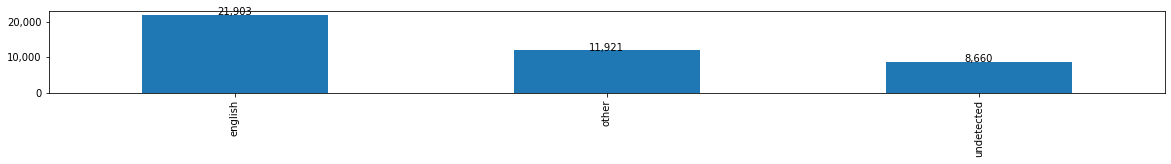

### Remove duplicates and restricted toy

,0
english,21903
other,11921
undetected,8660


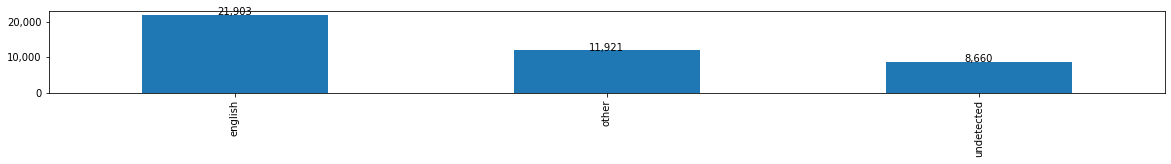

In [14]:
@calculate_auto(CONFIG, save_to="cnt", result=None)
@close_fig
def fn(notebooks, prefix):
    counter = Counter()
    notebooks["languages"].agg(
        lambda x: counter.update(
            {
                (y if y in ("english", "undetected") else "other")
                for y in x.split(",")
                if y
            }
        )
    )
    del counter[""]
    counts = pd.Series(counter).sort_values(ascending=False)
    # with savefig(prefix + "notebook_feature_run_line_magic", 9, 4):
    fig, cnt = display_counts(
        counts, width=20, show_values=True, plot=False, cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)
    return cnt

### Notebooks with english markdown

In [15]:
@calculate_auto(CONFIG)
def fn(cnt, total_with_markdown, prefix):
    return relative_var(
        prefix + "notebooks_with_english_markdown",
        cnt.loc["english", 0],
        total_with_markdown,
    )

### Default

21,903 (96.35%)


### Remove duplicates

21,903 (96.35%)


### Remove duplicates and toy

21,903 (96.35%)


### Remove duplicates and restricted toy

21,903 (96.35%)


### Notebooks with other languages

In [16]:
@calculate_auto(CONFIG)
def fn(cnt, total_with_markdown, prefix):
    return relative_var(
        prefix + "notebooks_with_other_markdown",
        cnt.loc["other", 0],
        total_with_markdown,
    )

### Default

11,921 (52.44%)


### Remove duplicates

11,921 (52.44%)


### Remove duplicates and toy

11,921 (52.44%)


### Remove duplicates and restricted toy

11,921 (52.44%)


### Notebooks with undetected cells

In [17]:
@calculate_auto(CONFIG)
def fn(cnt, total_with_markdown, prefix):
    return relative_var(
        prefix + "notebooks_with_undetected_markdown",
        cnt.loc["undetected", 0],
        total_with_markdown,
    )

### Default

8,660 (38.09%)


### Remove duplicates

8,660 (38.09%)


### Remove duplicates and toy

8,660 (38.09%)


### Remove duplicates and restricted toy

8,660 (38.09%)


### Venn

### Default

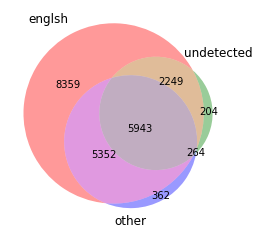

### Remove duplicates

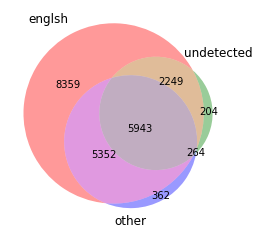

### Remove duplicates and toy

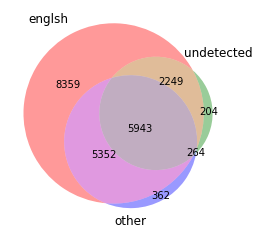

### Remove duplicates and restricted toy

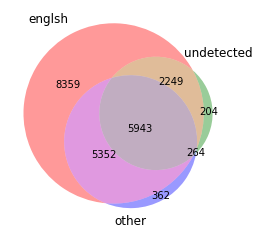

In [18]:
@calculate_auto(CONFIG)
@close_fig
def fn(notebooks, prefix):
    venn3(
        [
            set(
                notebooks[notebooks["languages"].str.contains("english")].index.tolist()
            ),
            set(
                notebooks[
                    notebooks["languages"].str.contains("undetected")
                ].index.tolist()
            ),
            set(
                notebooks[
                    notebooks["languages"]
                    .str.replace("english", "")
                    .str.replace("undetected", "")
                    .str.replace(",", "")
                    .str.len()
                    > 0
                ].index.tolist()
            ),
        ],
        set_labels=("englsh", "undetected", "other"),
    )

# Notebook Size

### Default

Distribution(min=0, q1=259.0, median=1175.0, q3=3640.0, max=2021168)


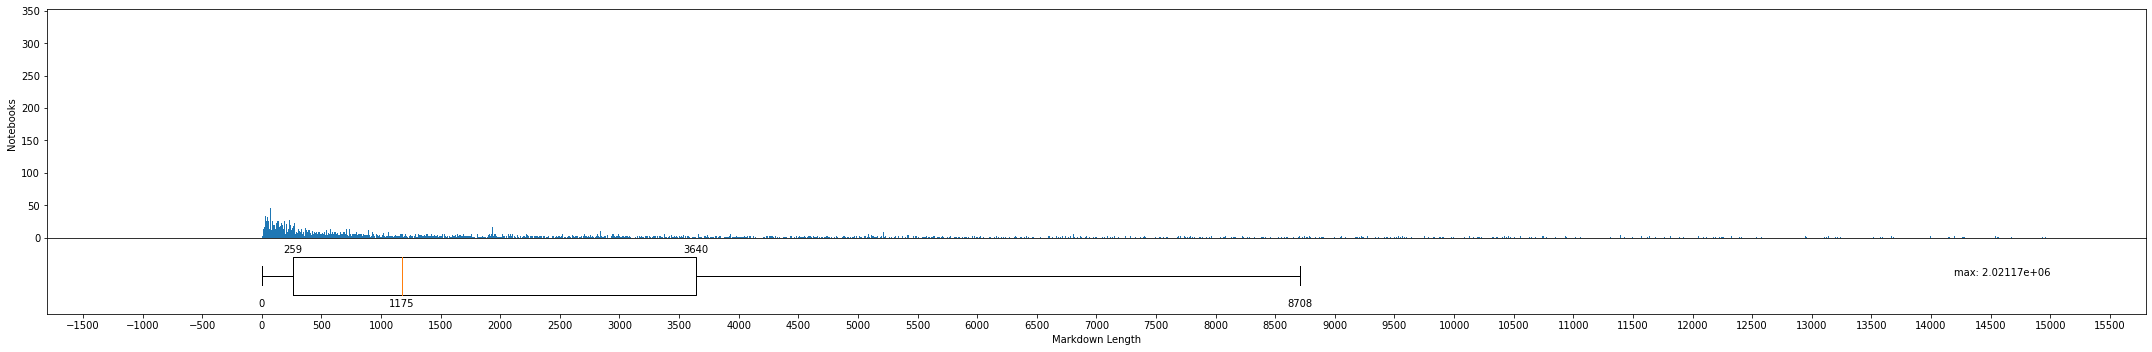

### Remove duplicates

Distribution(min=0, q1=259.0, median=1175.0, q3=3640.0, max=2021168)


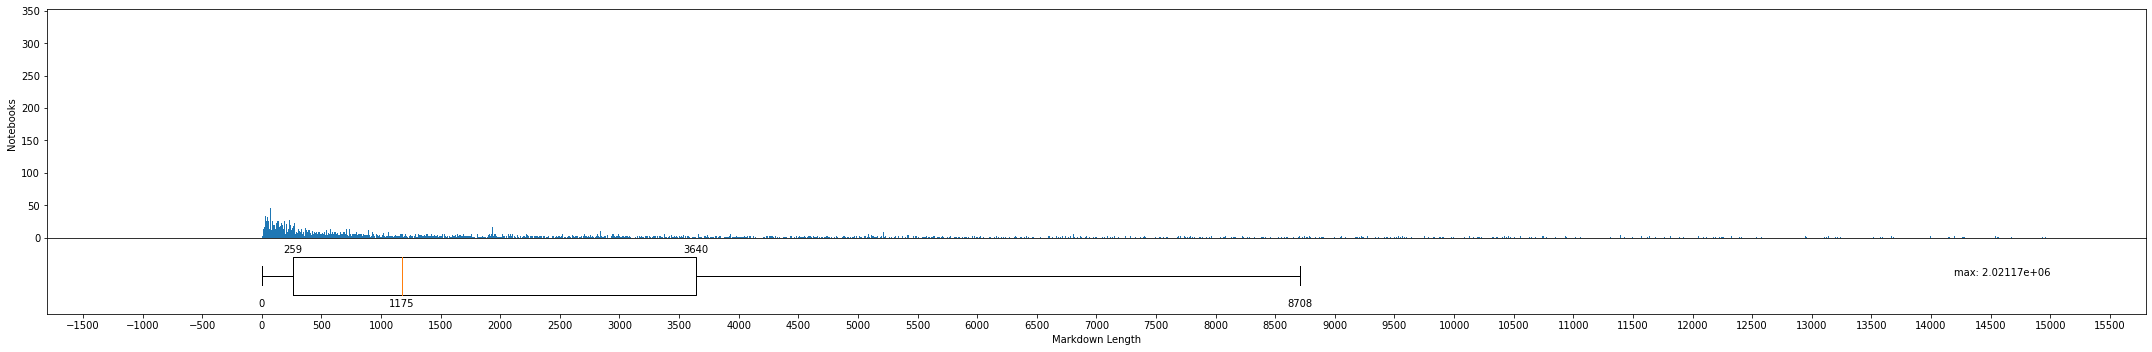

### Remove duplicates and toy

Distribution(min=0, q1=259.0, median=1175.0, q3=3640.0, max=2021168)


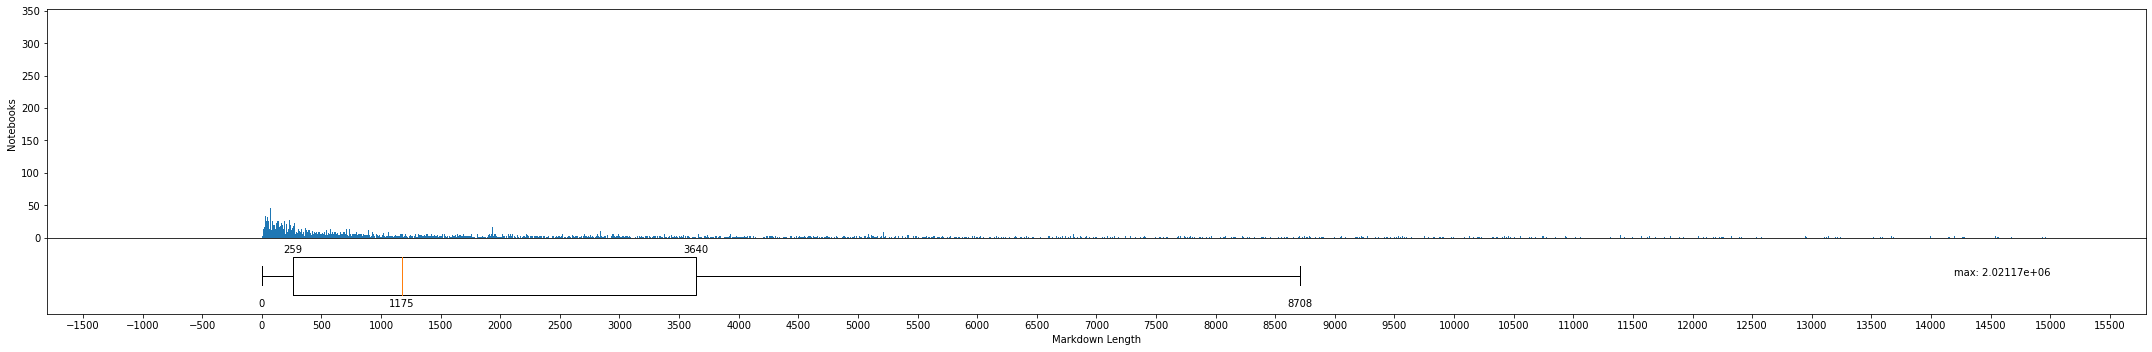

### Remove duplicates and restricted toy

Distribution(min=0, q1=259.0, median=1175.0, q3=3640.0, max=2021168)


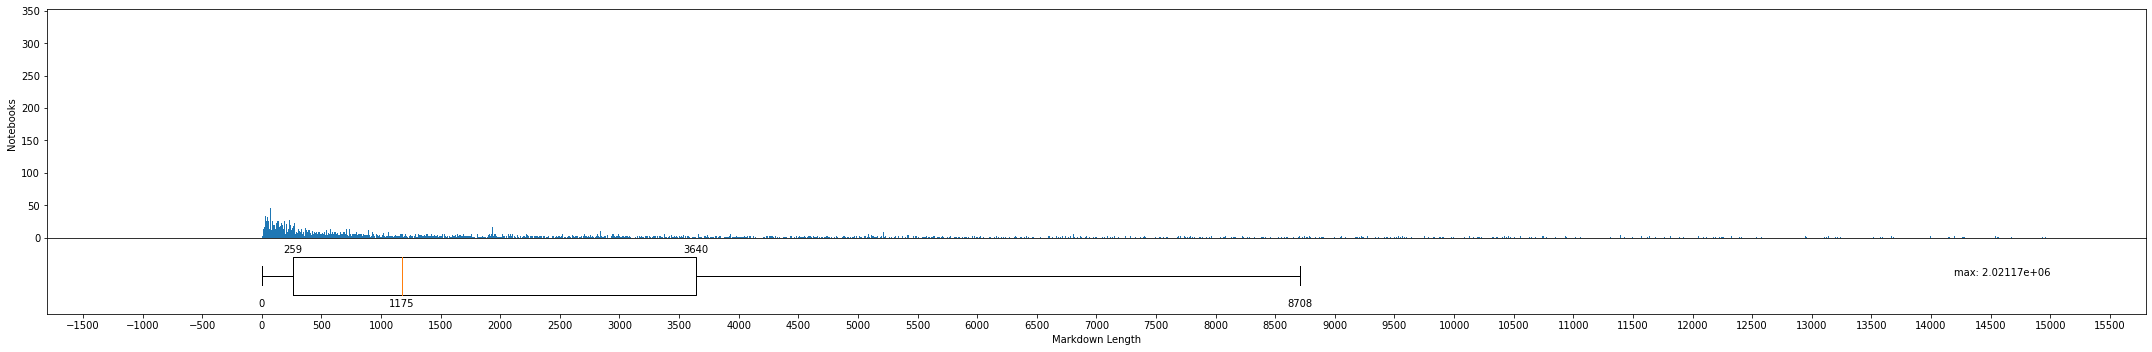

In [19]:
@calculate_auto(CONFIG)
@close_fig
def fn(notebooks, prefix):
    column = notebooks["len"]
    distribution = distribution_with_boxplot(
        column, -1000, 15000, 500, "Notebooks", "Markdown Length", True
    )
    print(distribution)

### Default

Distribution(min=1, q1=7.0, median=19.0, q3=48.0, max=1841)


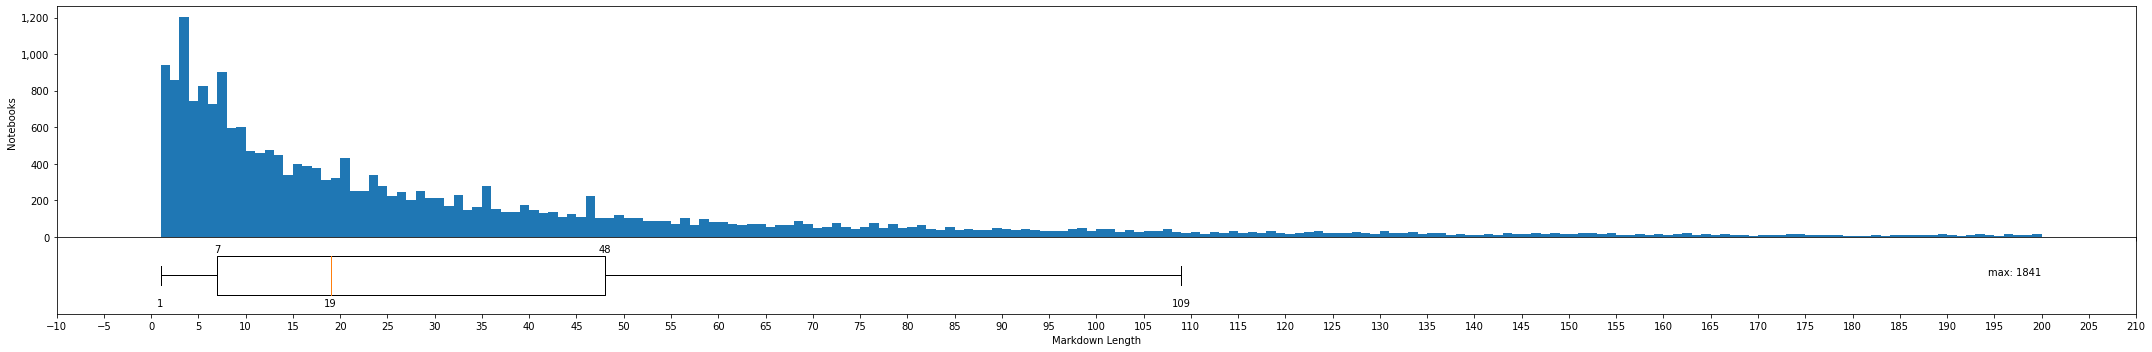

### Remove duplicates

Distribution(min=1, q1=7.0, median=19.0, q3=48.0, max=1841)


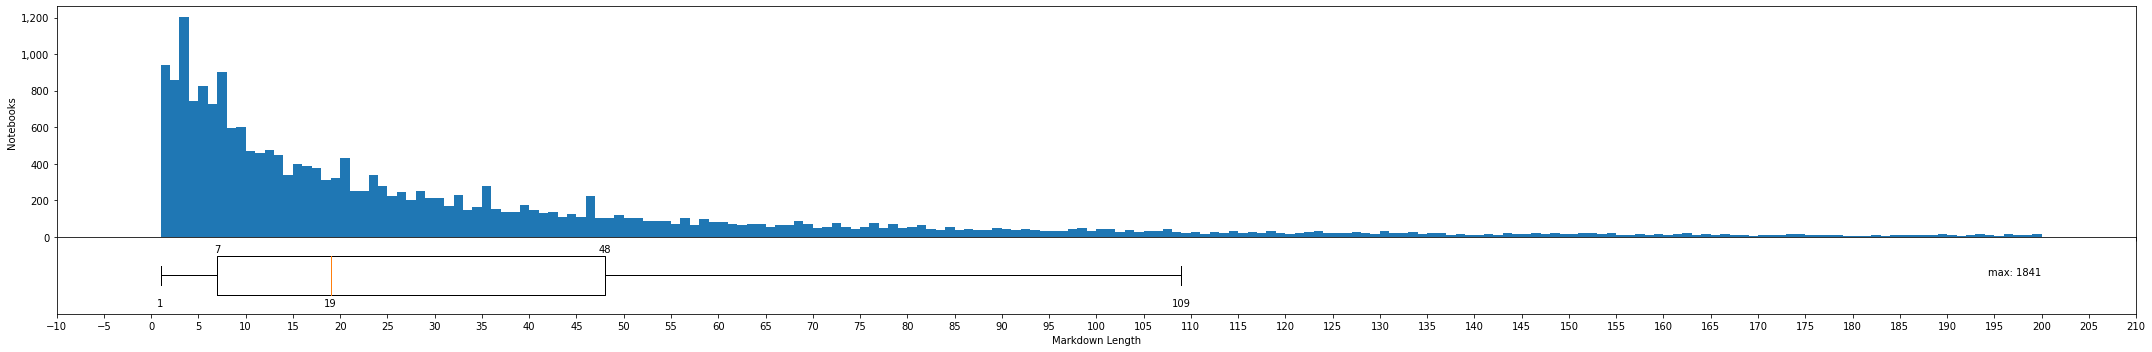

### Remove duplicates and toy

Distribution(min=1, q1=7.0, median=19.0, q3=48.0, max=1841)


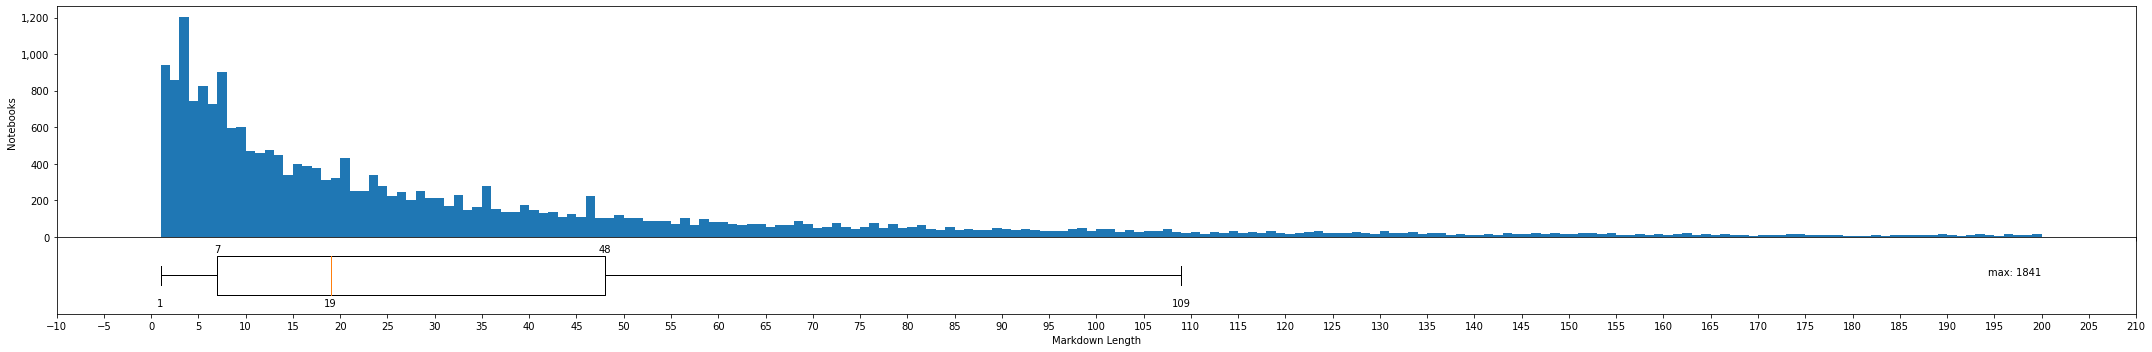

### Remove duplicates and restricted toy

Distribution(min=1, q1=7.0, median=19.0, q3=48.0, max=1841)


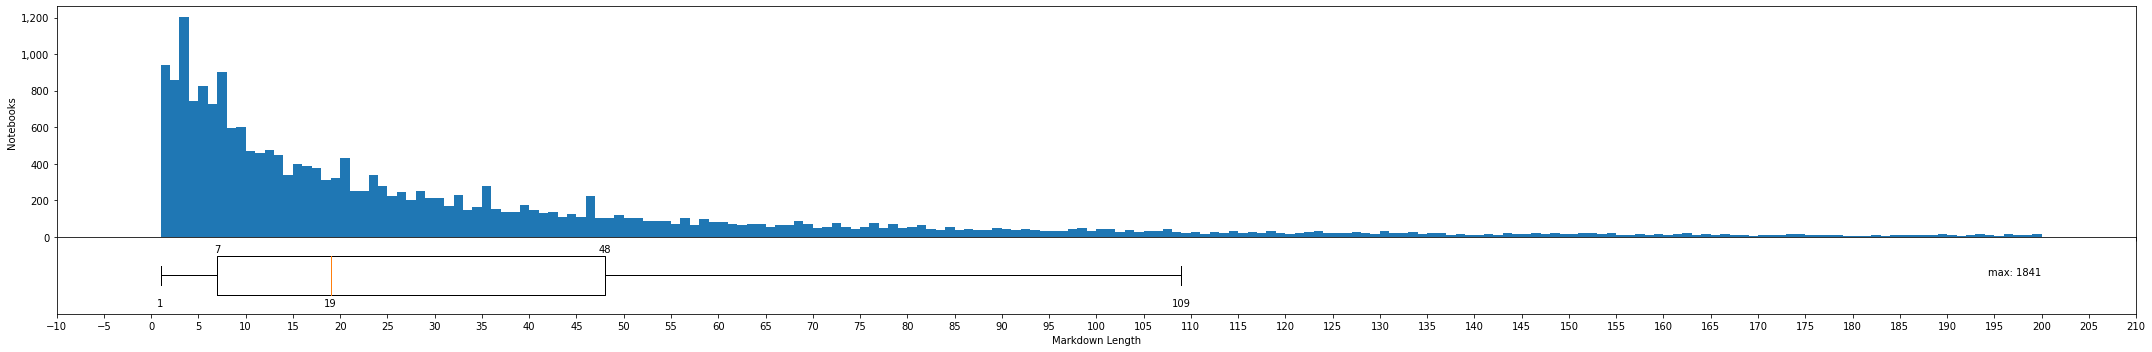

In [20]:
@calculate_auto(CONFIG)
@close_fig
def fn(notebooks, prefix):
    column = notebooks["lines"]
    distribution = distribution_with_boxplot(
        column, 0, 200, 5, "Notebooks", "Markdown Length", True
    )
    print(distribution)

### Default

Distribution(min=0, q1=10.0, median=24.0, q3=53.0, max=1798)


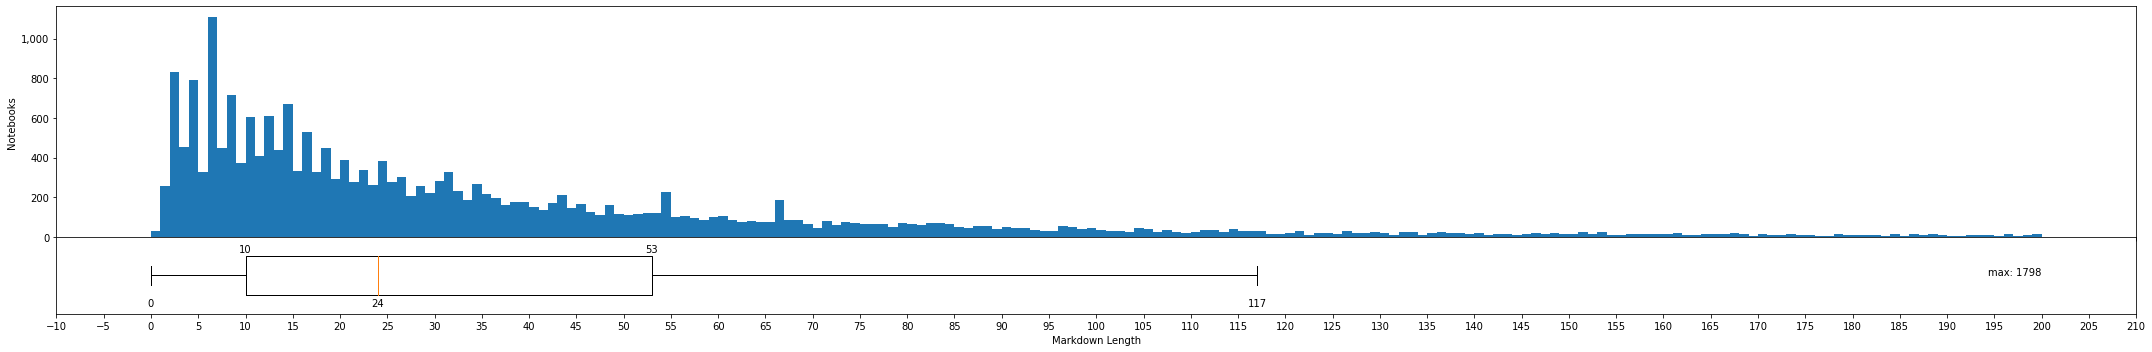

24


### Remove duplicates

Distribution(min=0, q1=10.0, median=24.0, q3=53.0, max=1798)


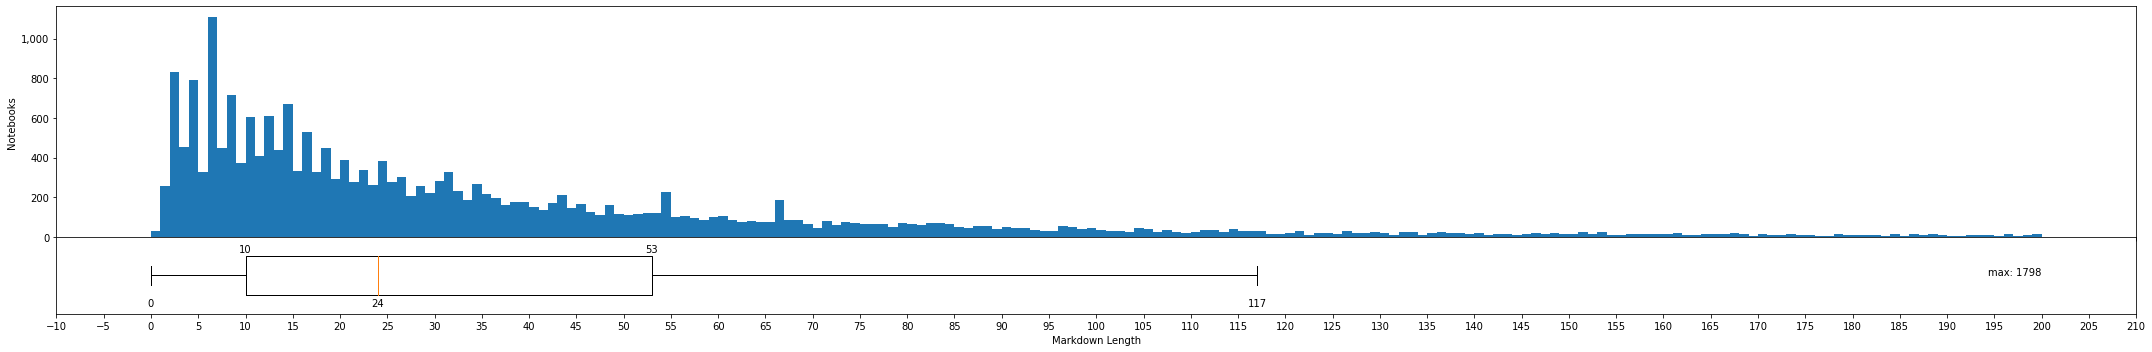

24


### Remove duplicates and toy

Distribution(min=0, q1=10.0, median=24.0, q3=53.0, max=1798)


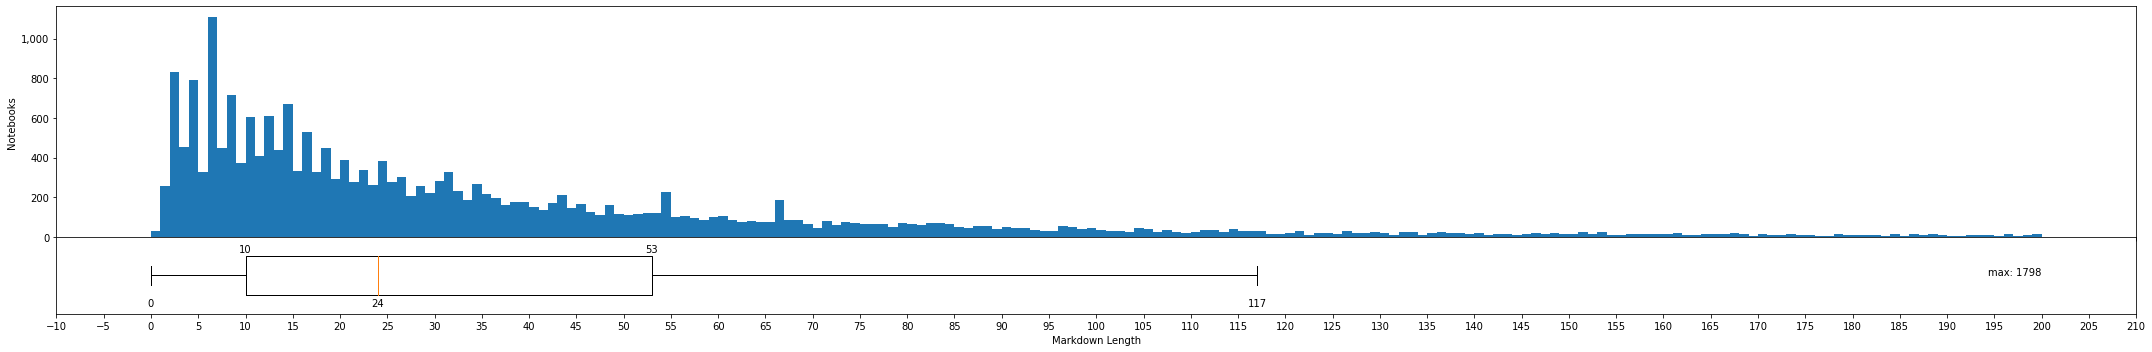

24


### Remove duplicates and restricted toy

Distribution(min=0, q1=10.0, median=24.0, q3=53.0, max=1798)


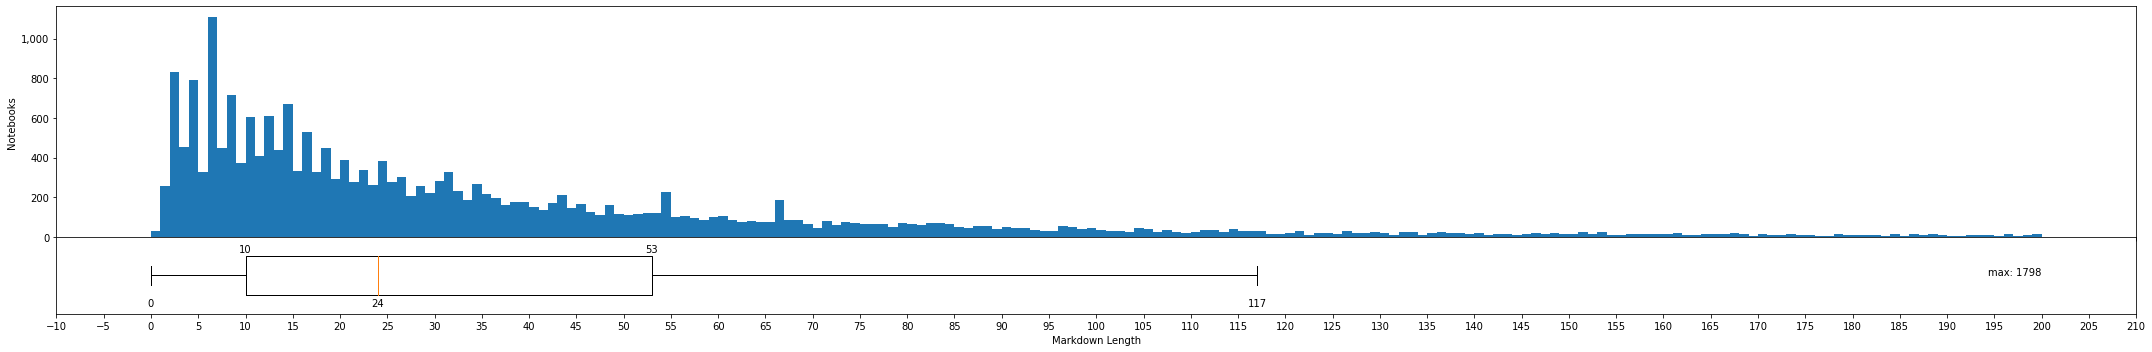

24


In [21]:
@calculate_auto(CONFIG)
@close_fig
def fn(notebooks, prefix):
    column = notebooks["meaningful_lines"]
    distribution = distribution_with_boxplot(
        column, 0, 200, 5, "Notebooks", "Markdown Length", True
    )
    print(distribution)
    return var(prefix + "markdown_lines_median", int(distribution.median))

### Default

Distribution(min=0, q1=39.0, median=152.0, q3=461.0, max=24758)


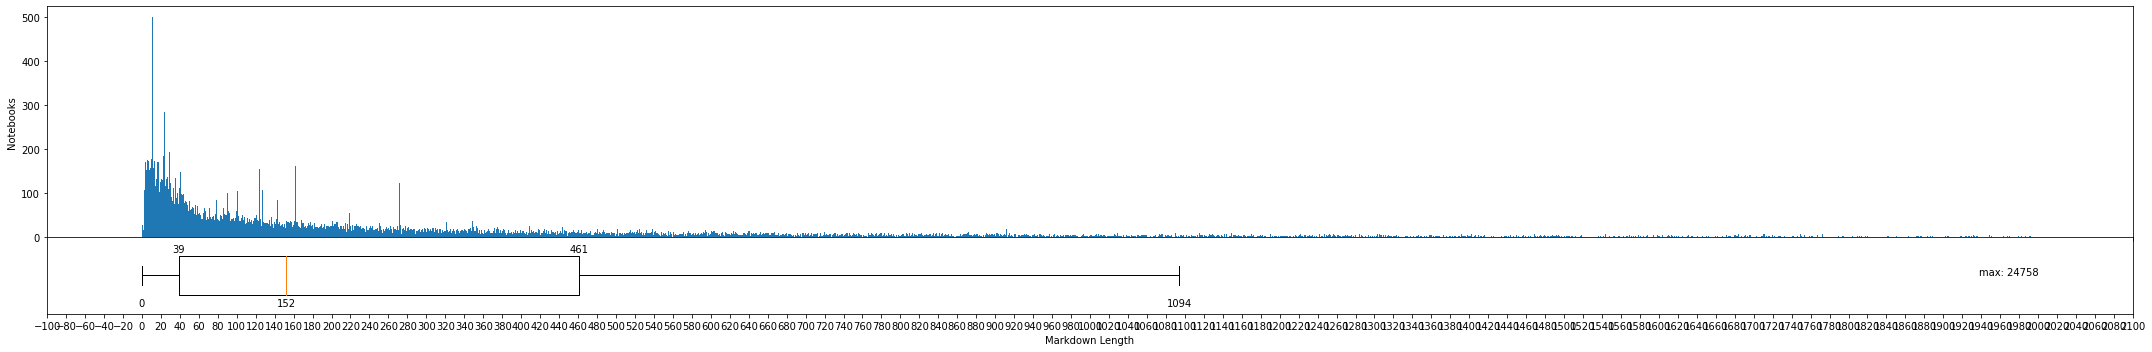

### Remove duplicates

Distribution(min=0, q1=39.0, median=152.0, q3=461.0, max=24758)


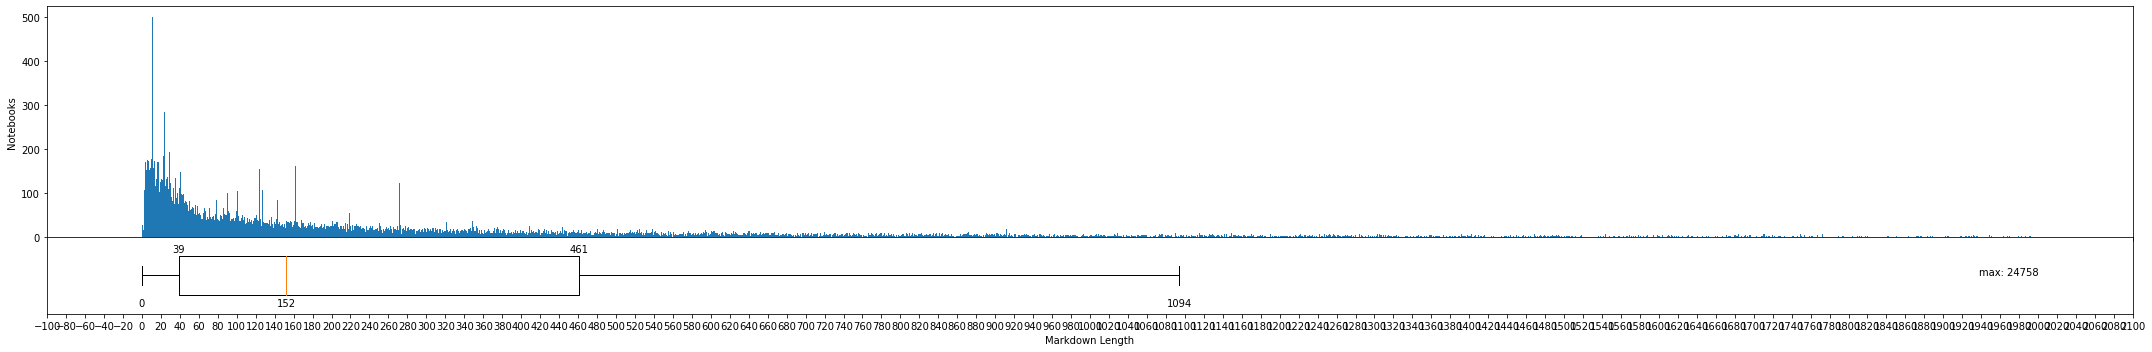

### Remove duplicates and toy

Distribution(min=0, q1=39.0, median=152.0, q3=461.0, max=24758)


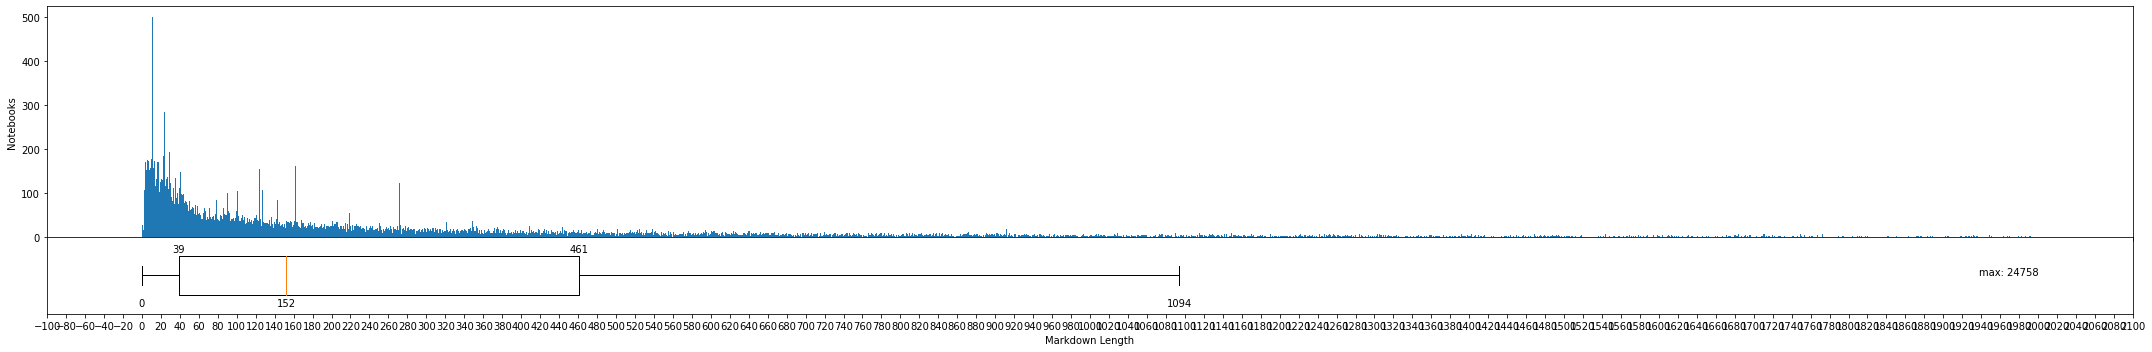

### Remove duplicates and restricted toy

Distribution(min=0, q1=39.0, median=152.0, q3=461.0, max=24758)


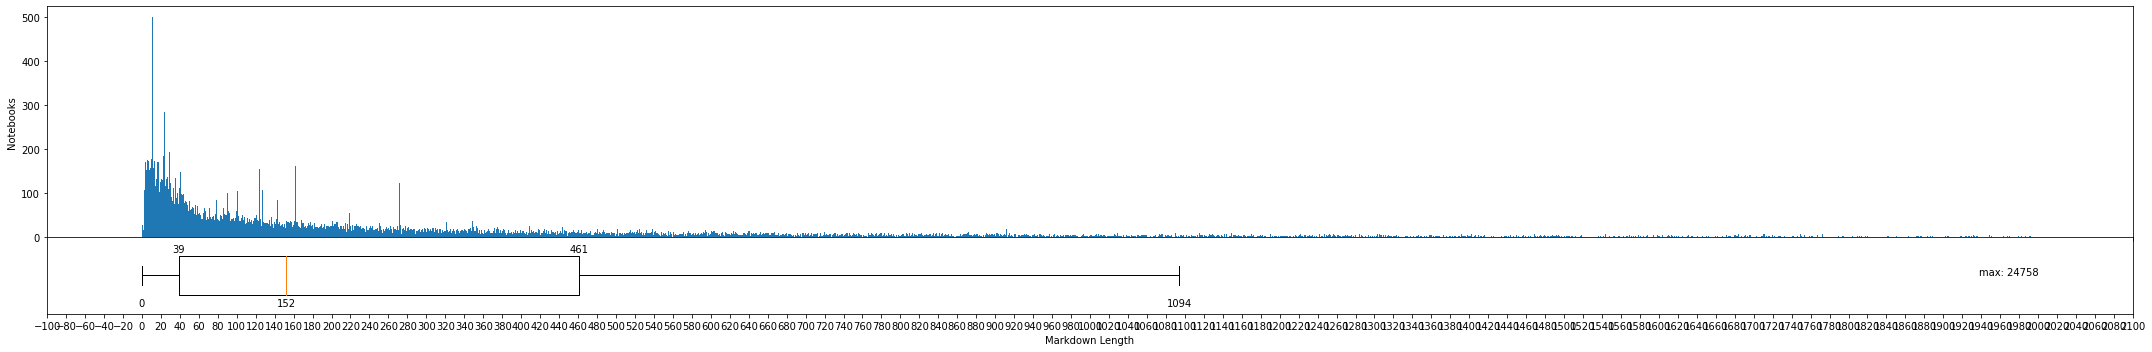

In [22]:
@calculate_auto(CONFIG)
@close_fig
def fn(notebooks, prefix):
    column = notebooks["words"]
    distribution = distribution_with_boxplot(
        column, 0, 2000, 20, "Notebooks", "Markdown Length", True
    )
    print(distribution)

### Default

Distribution(min=0, q1=31.0, median=127.0, q3=431.0, max=14457)


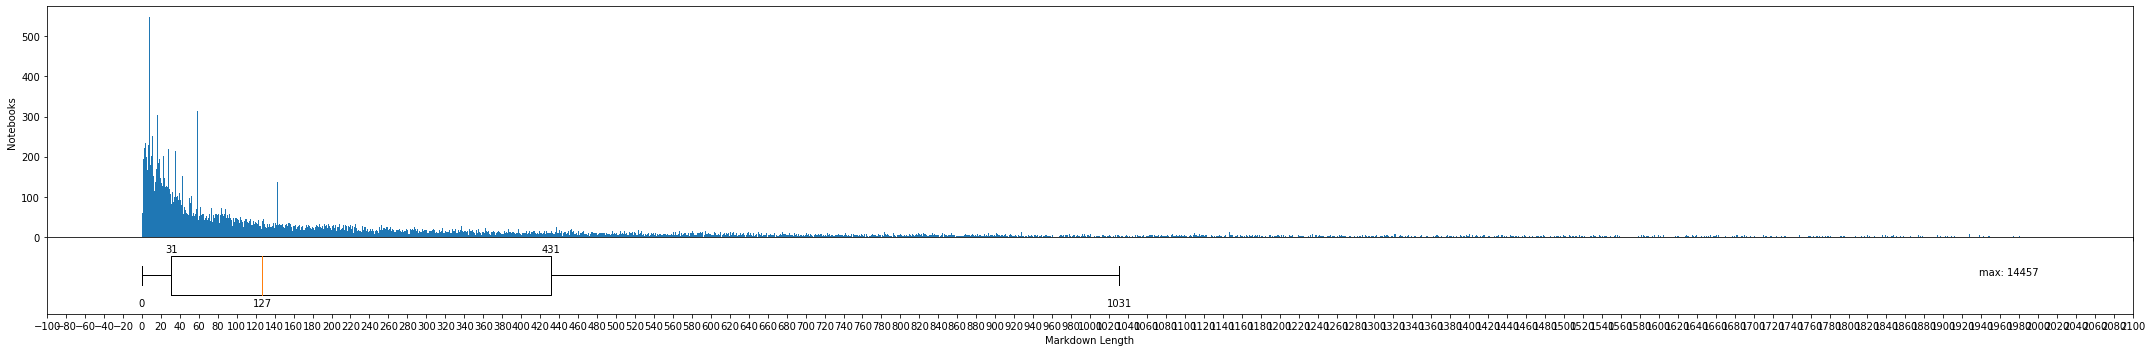

127


### Remove duplicates

Distribution(min=0, q1=31.0, median=127.0, q3=431.0, max=14457)


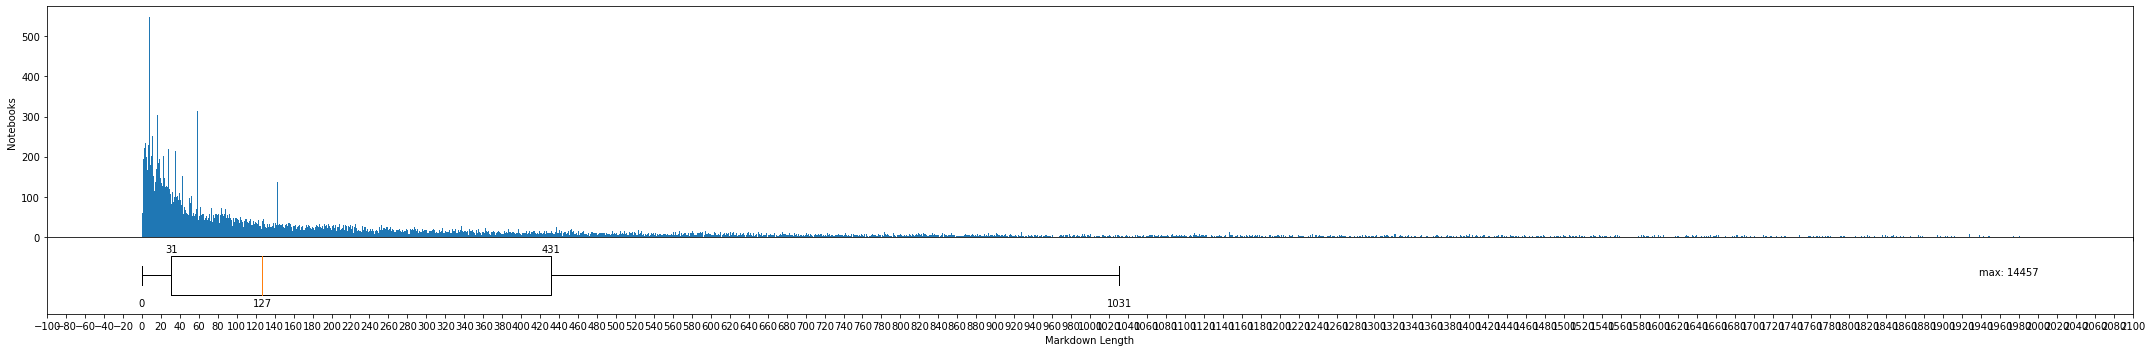

127


### Remove duplicates and toy

Distribution(min=0, q1=31.0, median=127.0, q3=431.0, max=14457)


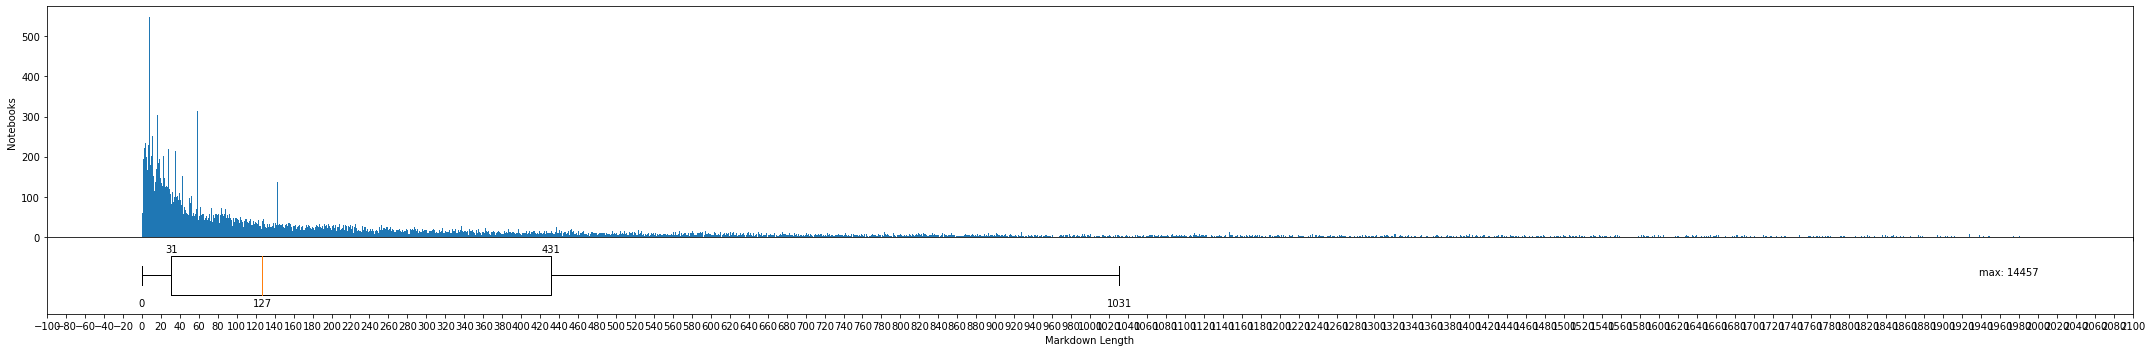

127


### Remove duplicates and restricted toy

Distribution(min=0, q1=31.0, median=127.0, q3=431.0, max=14457)


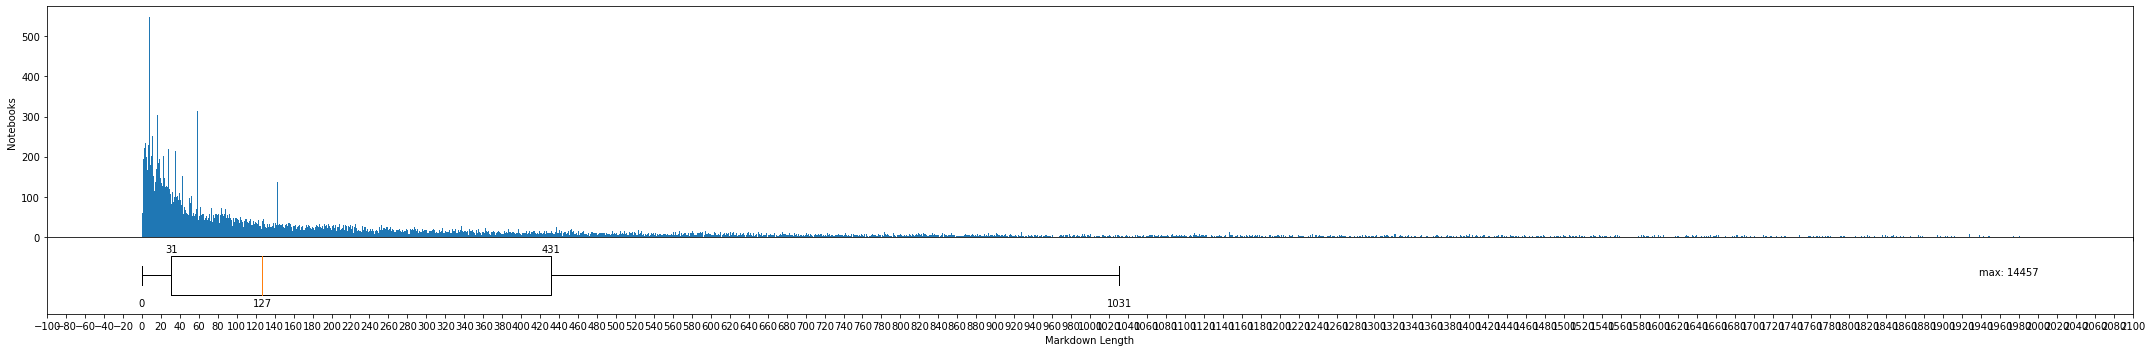

127


In [23]:
@calculate_auto(CONFIG)
@close_fig
def fn(notebooks, prefix):
    column = notebooks["meaningful_words"]
    distribution = distribution_with_boxplot(
        column, 0, 2000, 20, "Notebooks", "Markdown Length", True
    )
    print(distribution)
    return var(prefix + "markdown_words_median", int(distribution.median))

### Default

Distribution(min=0, q1=4.0, median=28.0, q3=134.0, max=5354)


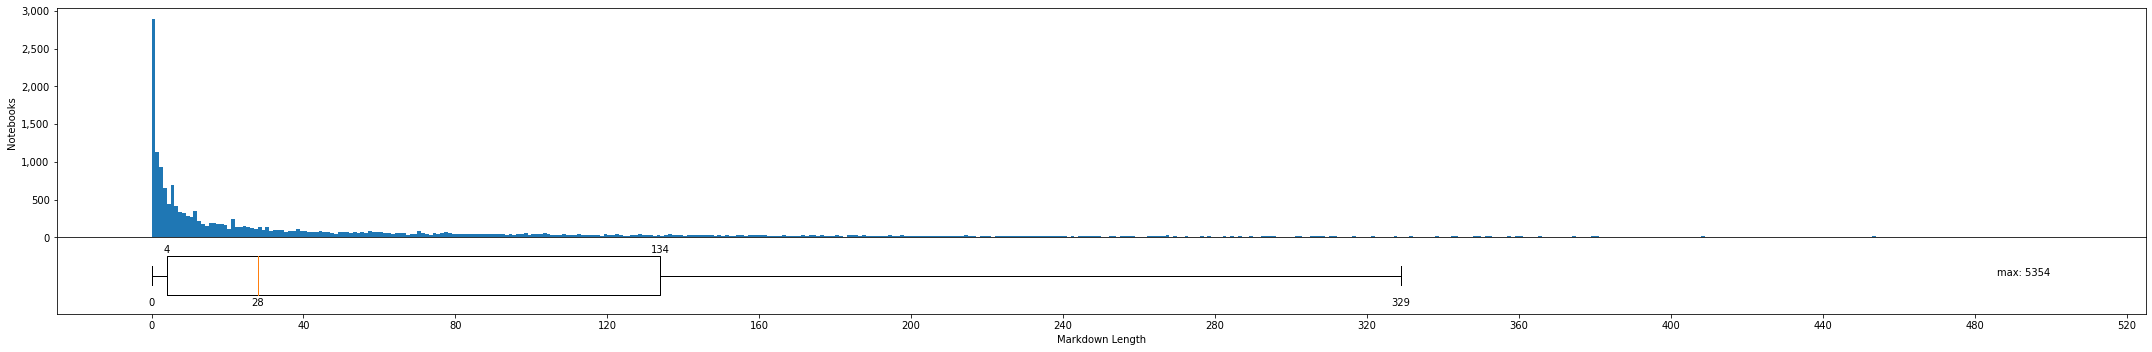

### Remove duplicates

Distribution(min=0, q1=4.0, median=28.0, q3=134.0, max=5354)


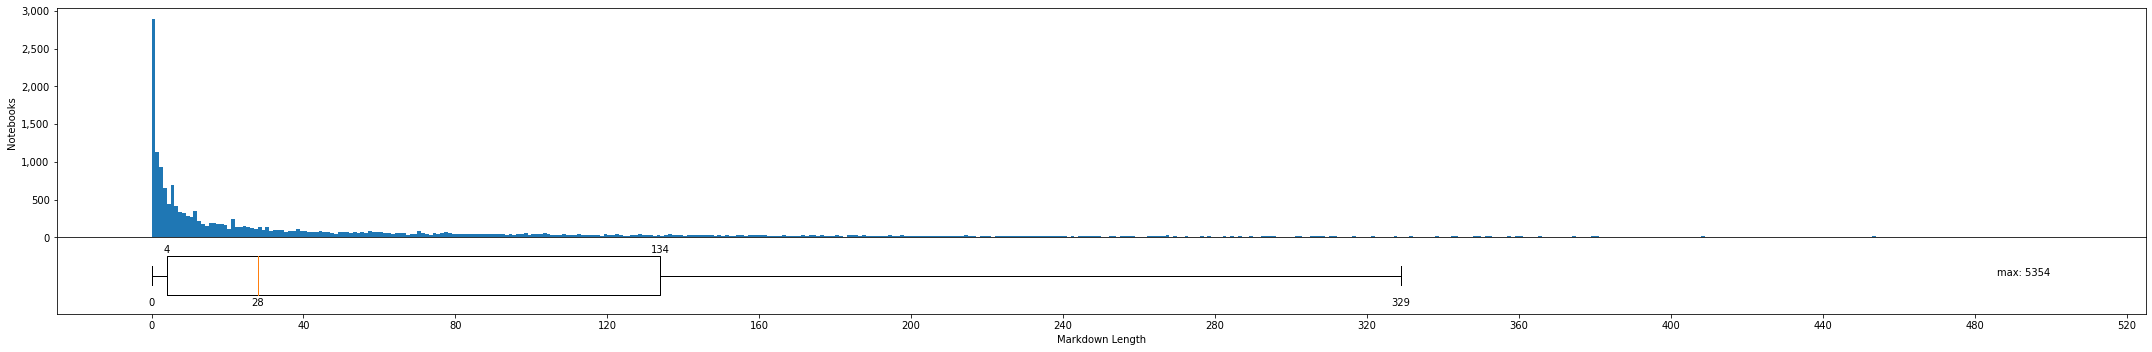

### Remove duplicates and toy

Distribution(min=0, q1=4.0, median=28.0, q3=134.0, max=5354)


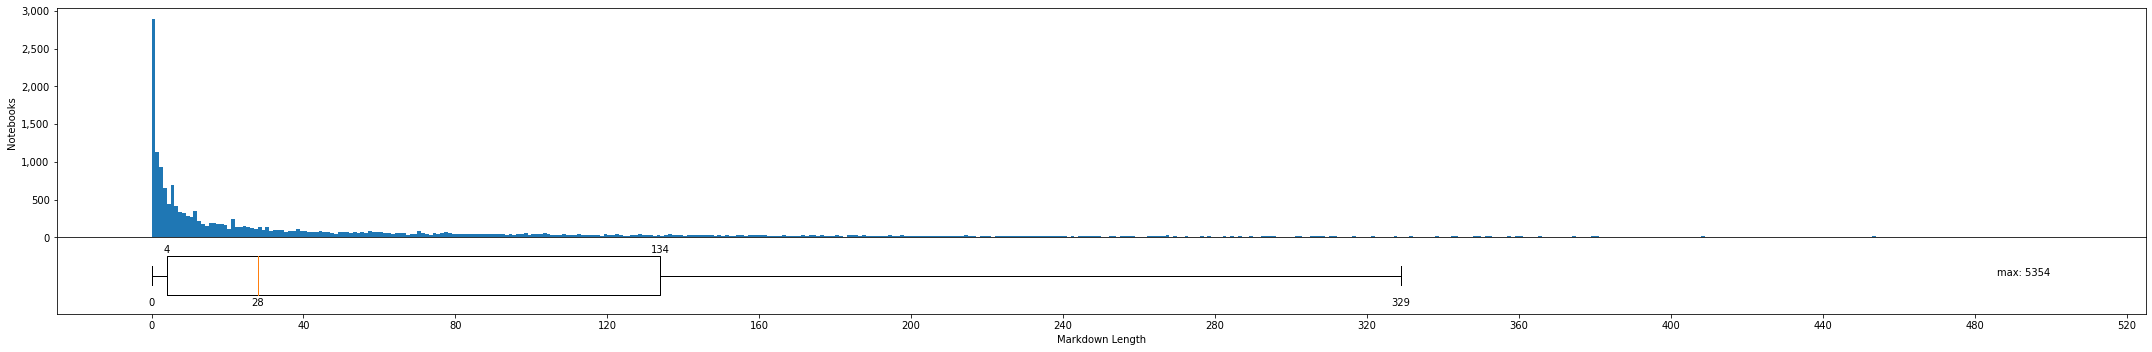

### Remove duplicates and restricted toy

Distribution(min=0, q1=4.0, median=28.0, q3=134.0, max=5354)


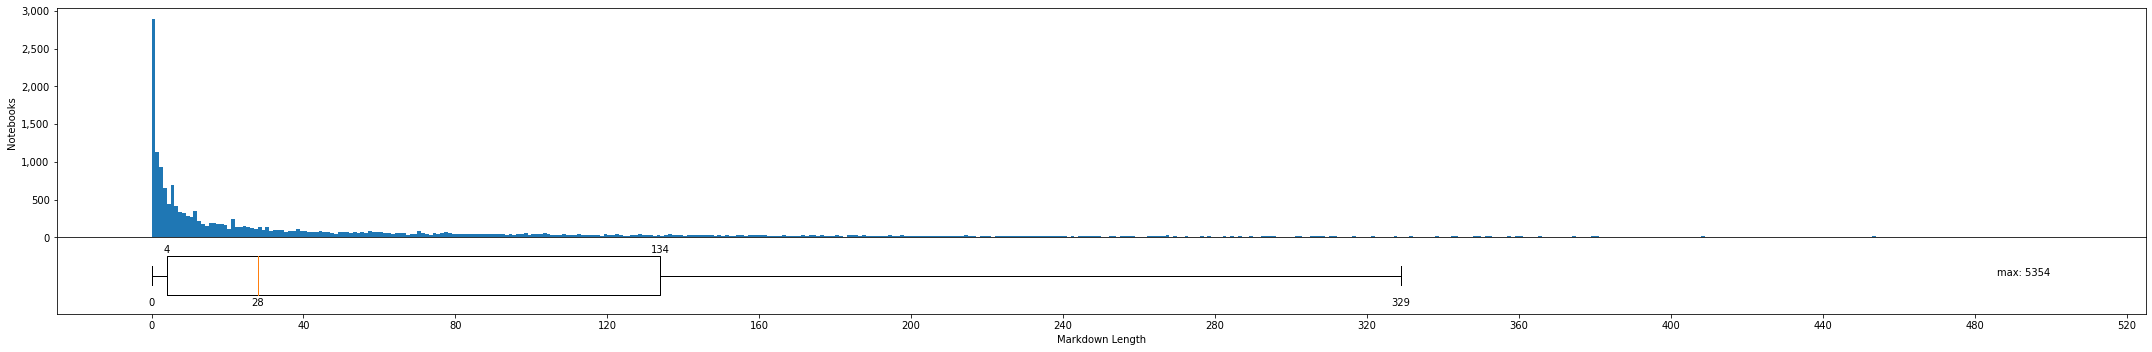

In [24]:
@calculate_auto(CONFIG)
@close_fig
def fn(notebooks, prefix):
    column = notebooks["stopwords"]
    distribution = distribution_with_boxplot(
        column, 0, 500, 40, "Notebooks", "Markdown Length", True
    )
    print(distribution)

### Default

Distribution(min=0, q1=3.0, median=27.0, q3=130.0, max=4382)


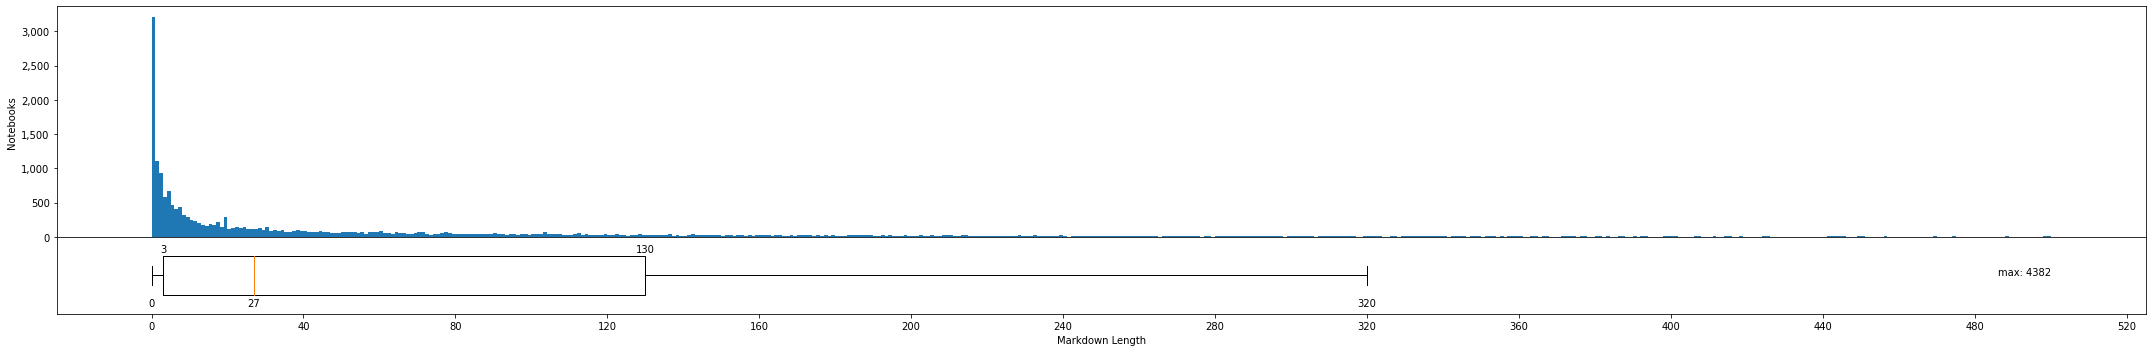

27


### Remove duplicates

Distribution(min=0, q1=3.0, median=27.0, q3=130.0, max=4382)


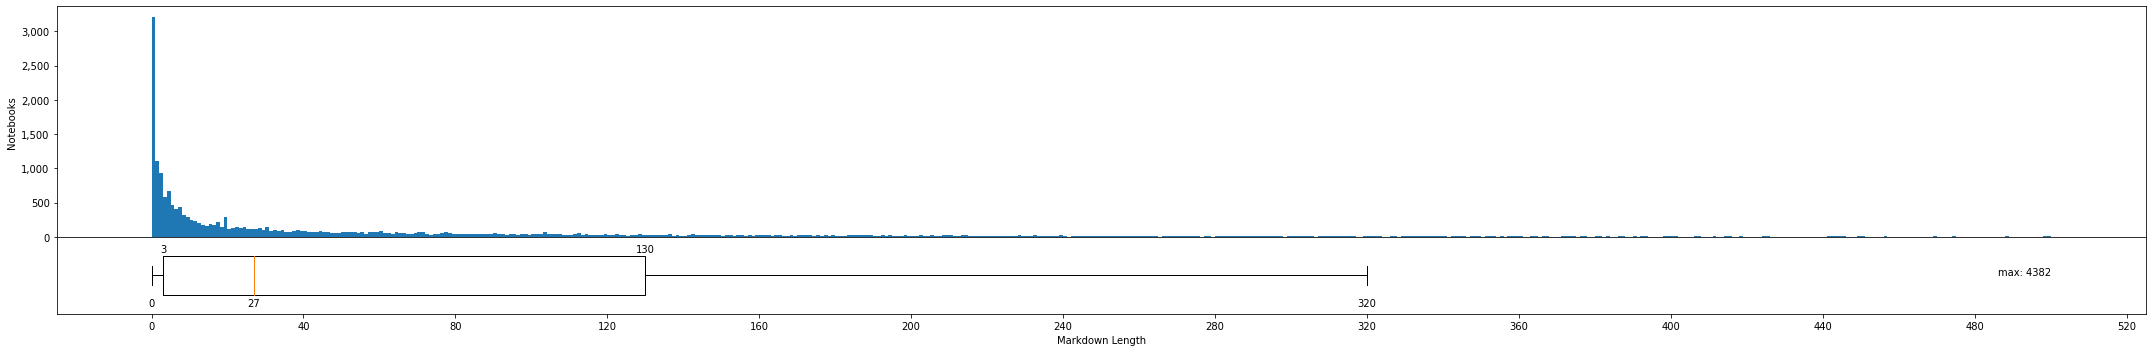

27


### Remove duplicates and toy

Distribution(min=0, q1=3.0, median=27.0, q3=130.0, max=4382)


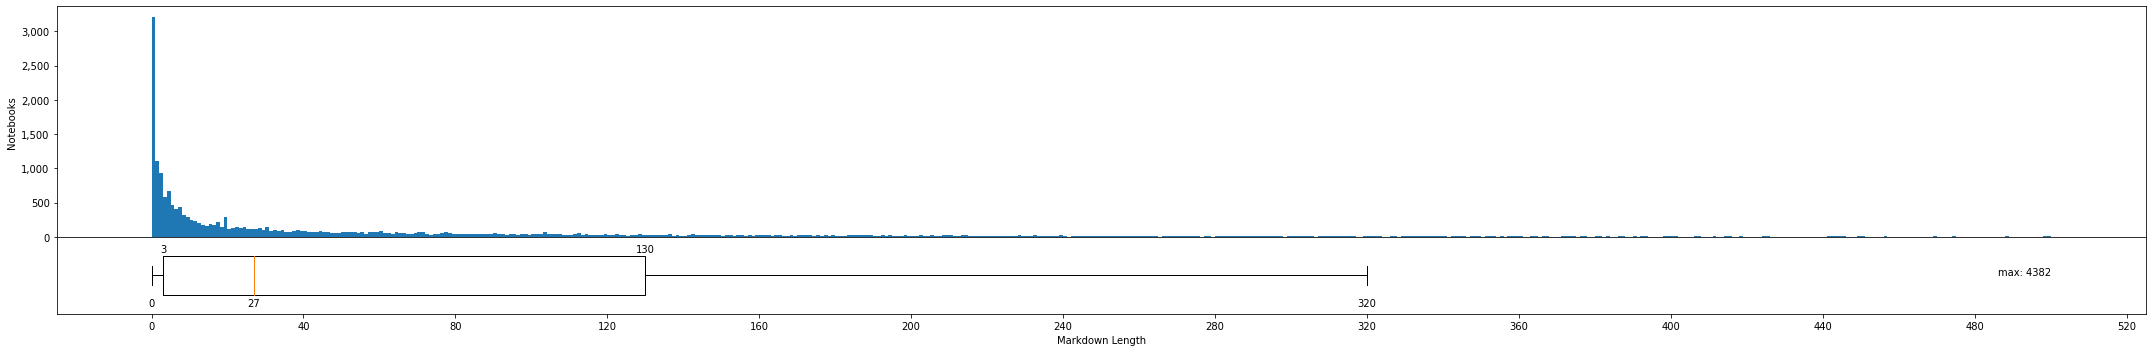

27


### Remove duplicates and restricted toy

Distribution(min=0, q1=3.0, median=27.0, q3=130.0, max=4382)


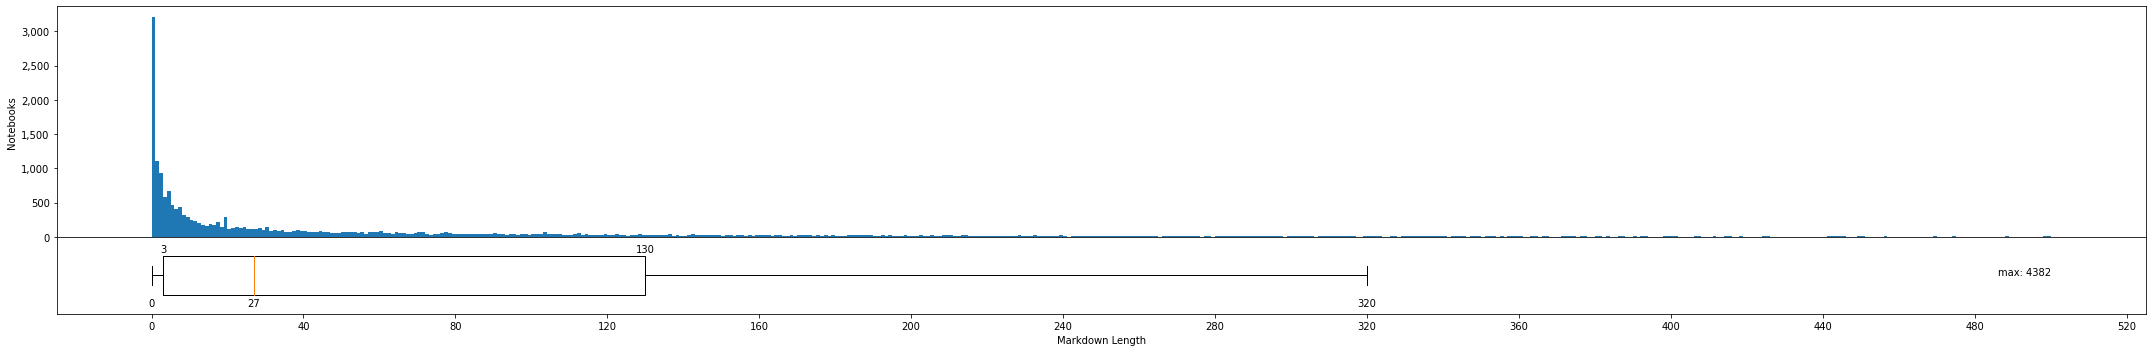

27


In [25]:
@calculate_auto(CONFIG)
@close_fig
def fn(notebooks, prefix):
    column = notebooks["meaningful_stopwords"]
    distribution = distribution_with_boxplot(
        column, 0, 500, 40, "Notebooks", "Markdown Length", True
    )
    print(distribution)
    return var(prefix + "markdown_stopwords_median", int(distribution.median))

# Elements

In [26]:
@calculate_auto(CONFIG, save_to="counter", result=None)
def fn(notebooks, total_with_markdown, prefix):
    counter = count(
        notebooks,
        "header",
        "h1",
        "h2",
        "h3",
        "h4",
        "h5",
        "h6",
        "hrule",
        "list",
        "table",
        "p",
        "quote",
        "code",
        "image",
        "link",
        "autolink",
        "codespan",
        "emphasis",
        "double_emphasis",
        "strikethrough",
        "html",
        "math",
        "block_math",
        "latex",
    )
    print(
        "Notebooks with header",
        relative_var(
            prefix + "markdown_header_notebooks", counter["header"], total_with_markdown
        ),
    )
    print(
        "Notebooks with p",
        relative_var(
            prefix + "markdown_p_notebooks", counter["p"], total_with_markdown
        ),
    )
    return counter

### Default

Notebooks with header 21,526 (94.69%)
Notebooks with p 17,649 (77.64%)


### Remove duplicates

Notebooks with header 21,526 (94.69%)
Notebooks with p 17,649 (77.64%)


### Remove duplicates and toy

Notebooks with header 21,526 (94.69%)
Notebooks with p 17,649 (77.64%)


### Remove duplicates and restricted toy

Notebooks with header 21,526 (94.69%)
Notebooks with p 17,649 (77.64%)


### Default

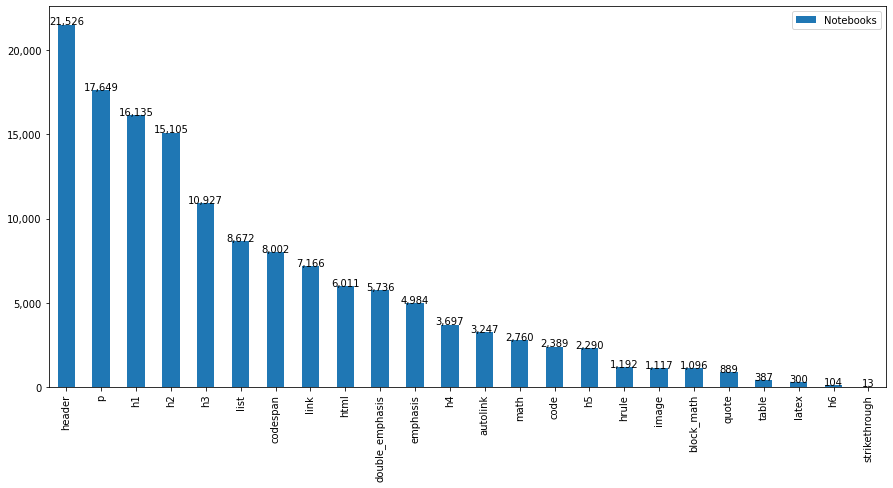

,Notebooks
header,21526
p,17649
h1,16135
h2,15105
h3,10927
list,8672
codespan,8002
link,7166
html,6011
double_emphasis,5736


<Figure size 432x288 with 0 Axes>

### Remove duplicates

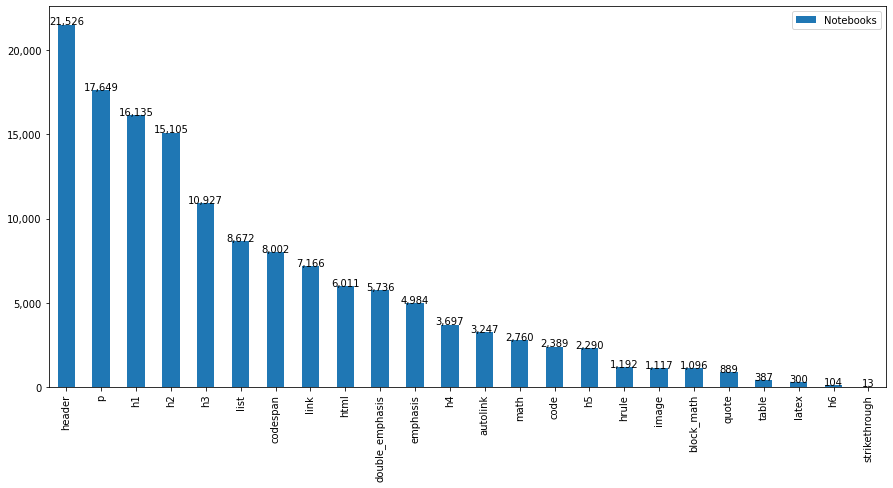

,Notebooks
header,21526
p,17649
h1,16135
h2,15105
h3,10927
list,8672
codespan,8002
link,7166
html,6011
double_emphasis,5736


<Figure size 432x288 with 0 Axes>

### Remove duplicates and toy

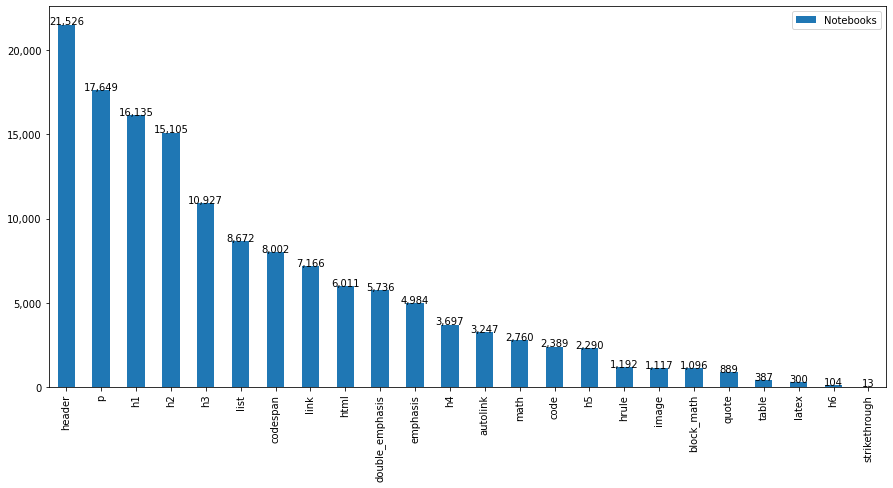

,Notebooks
header,21526
p,17649
h1,16135
h2,15105
h3,10927
list,8672
codespan,8002
link,7166
html,6011
double_emphasis,5736


<Figure size 432x288 with 0 Axes>

### Remove duplicates and restricted toy

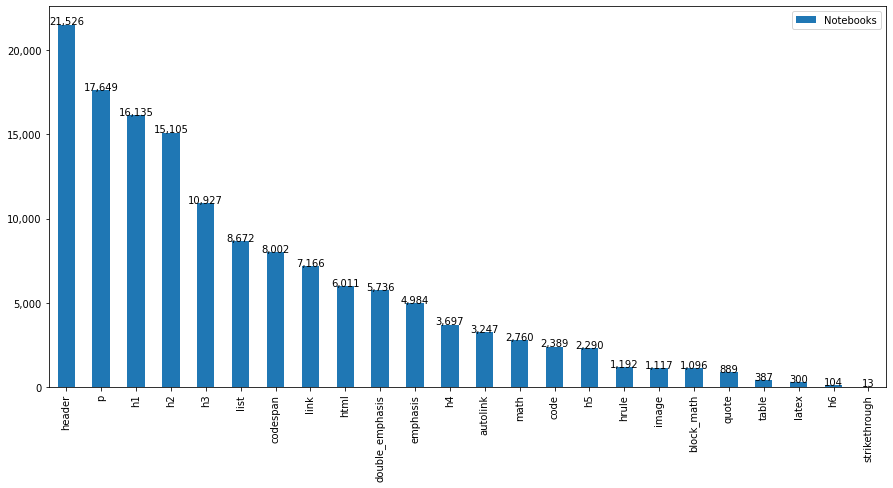

,Notebooks
header,21526
p,17649
h1,16135
h2,15105
h3,10927
list,8672
codespan,8002
link,7166
html,6011
double_emphasis,5736


<Figure size 432x288 with 0 Axes>

In [27]:
@calculate_auto(CONFIG)
@close_fig
def fn(counter, prefix):
    counter_hist(
        counter,
        label="Notebooks",
        width=15,
        show_values=True,
        template="{:,}",
        template2="{:,.0f}",
        logy=False,
    )

# Header size

### Default

Distribution(min=0, q1=8.0, median=21.0, q3=42.0, max=1876)


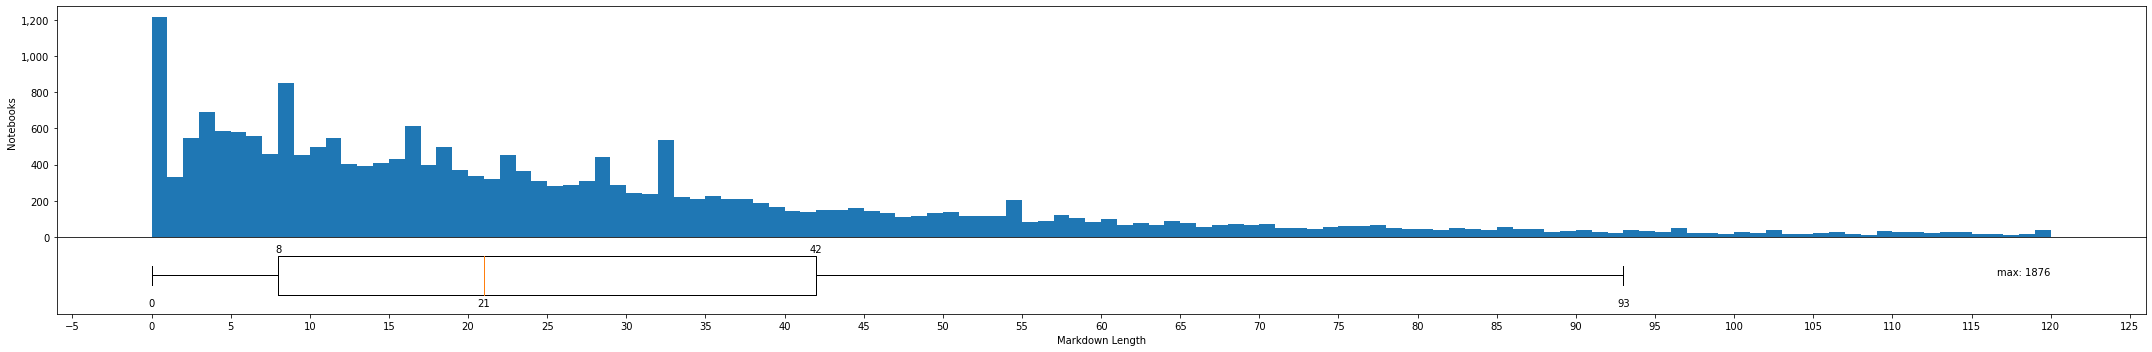

21


### Remove duplicates

Distribution(min=0, q1=8.0, median=21.0, q3=42.0, max=1876)


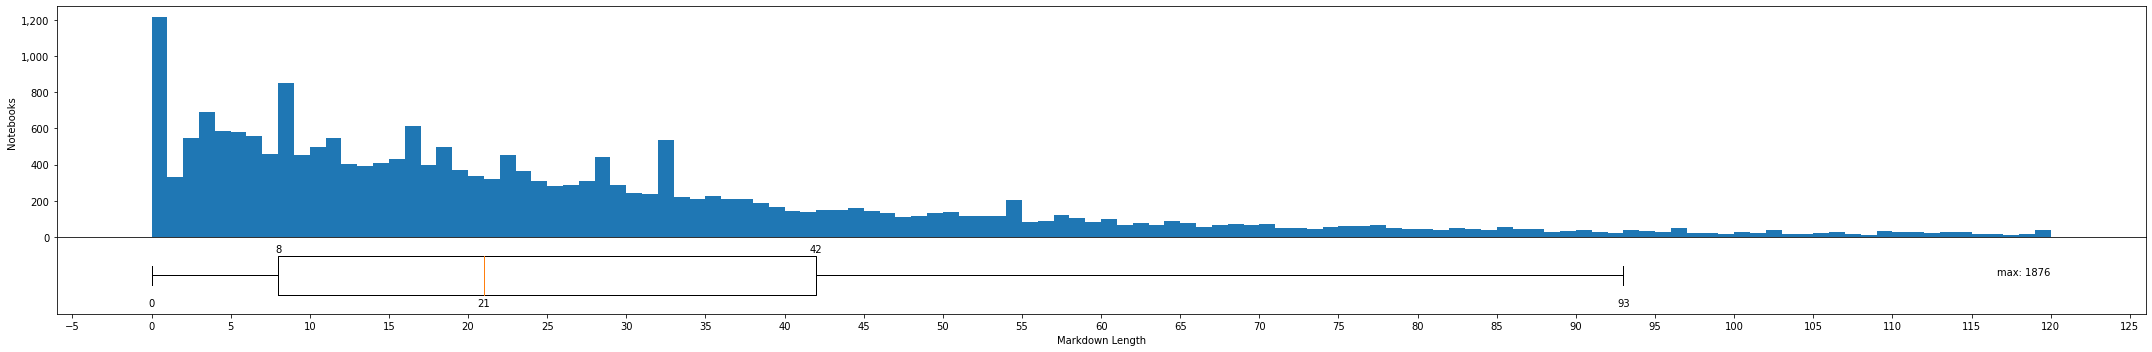

21


### Remove duplicates and toy

Distribution(min=0, q1=8.0, median=21.0, q3=42.0, max=1876)


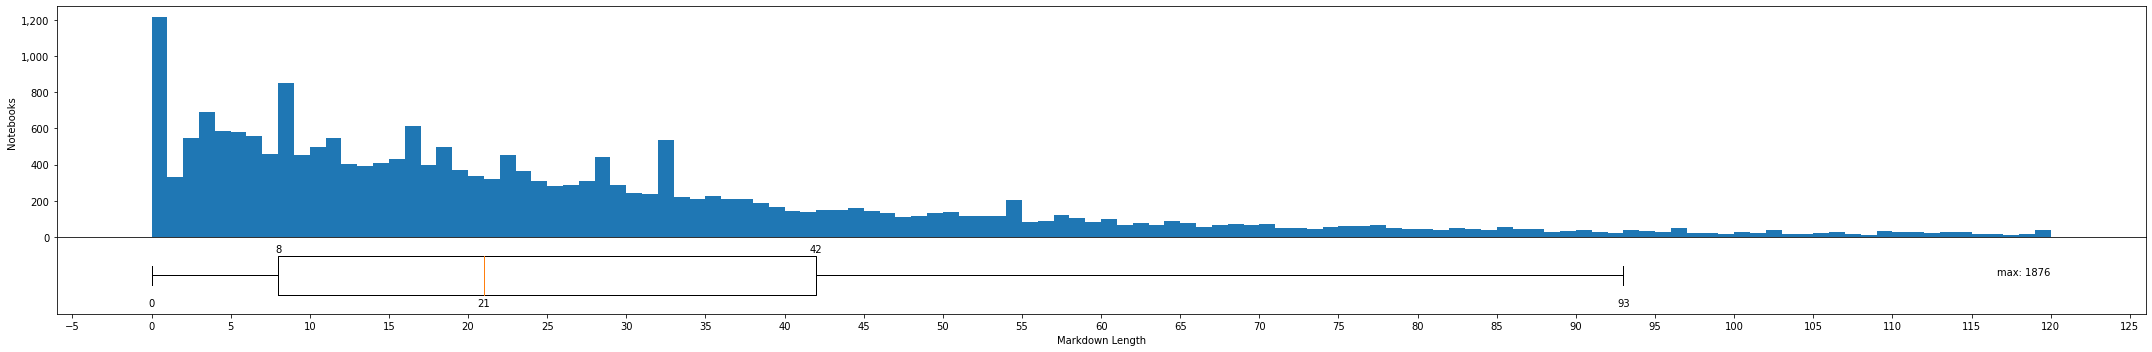

21


### Remove duplicates and restricted toy

Distribution(min=0, q1=8.0, median=21.0, q3=42.0, max=1876)


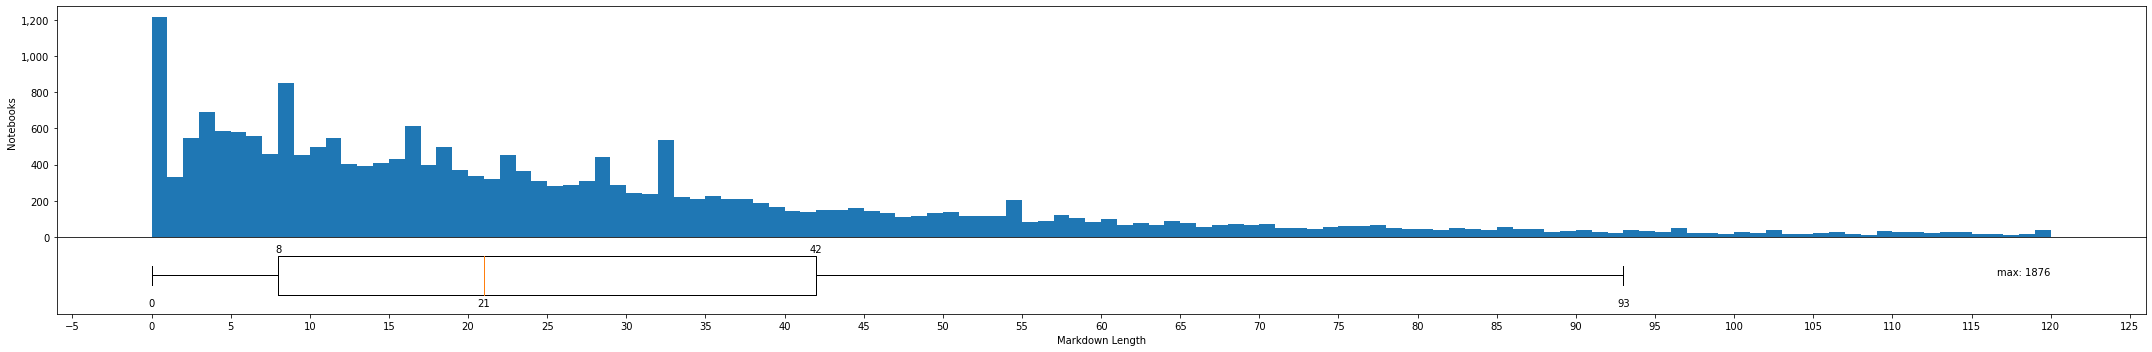

21


In [28]:
@calculate_auto(CONFIG)
@close_fig
def fn(notebooks, prefix):
    column = notebooks["header_words"]
    distribution = distribution_with_boxplot(
        column, 0, 120, 5, "Notebooks", "Markdown Length", True
    )
    print(distribution)
    return var(prefix + "markdown_header_words_median", int(distribution.median))

# P size

### Default

Distribution(min=0, q1=1.0, median=68.0, q3=314.0, max=11571)


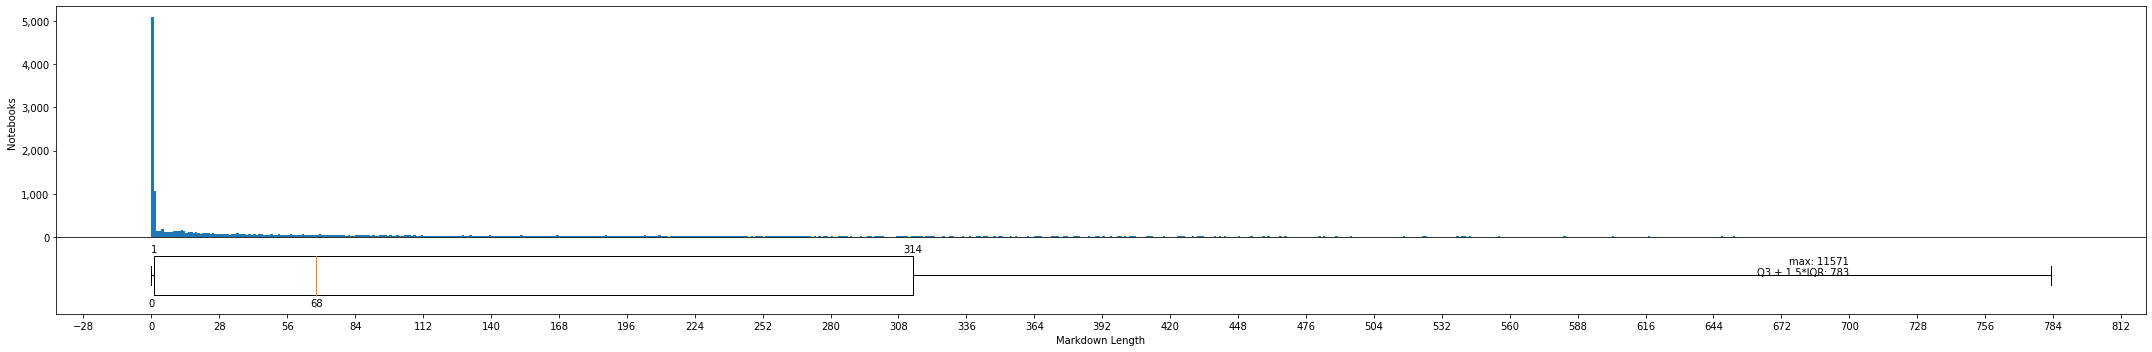

68


### Remove duplicates

Distribution(min=0, q1=1.0, median=68.0, q3=314.0, max=11571)


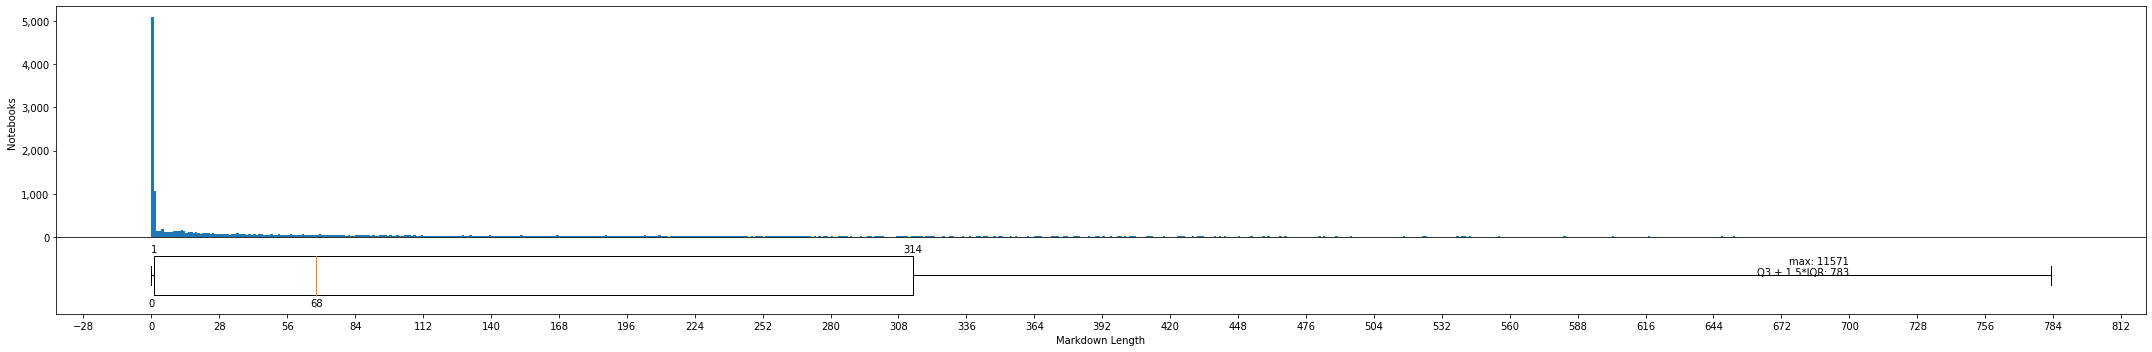

68


### Remove duplicates and toy

Distribution(min=0, q1=1.0, median=68.0, q3=314.0, max=11571)


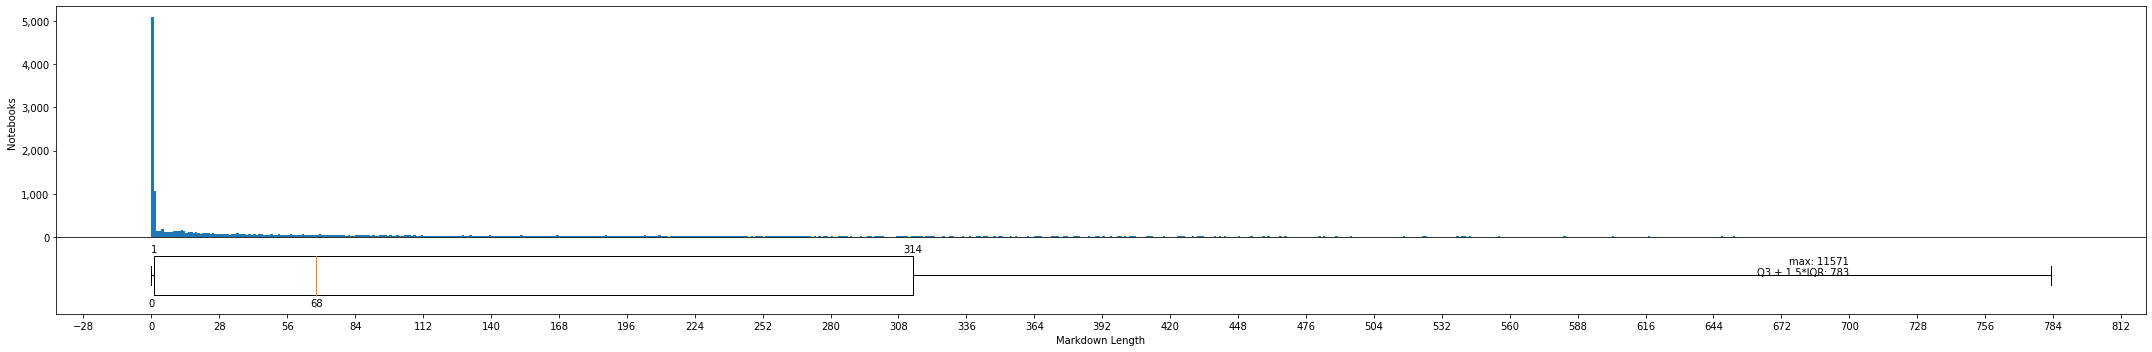

68


### Remove duplicates and restricted toy

Distribution(min=0, q1=1.0, median=68.0, q3=314.0, max=11571)


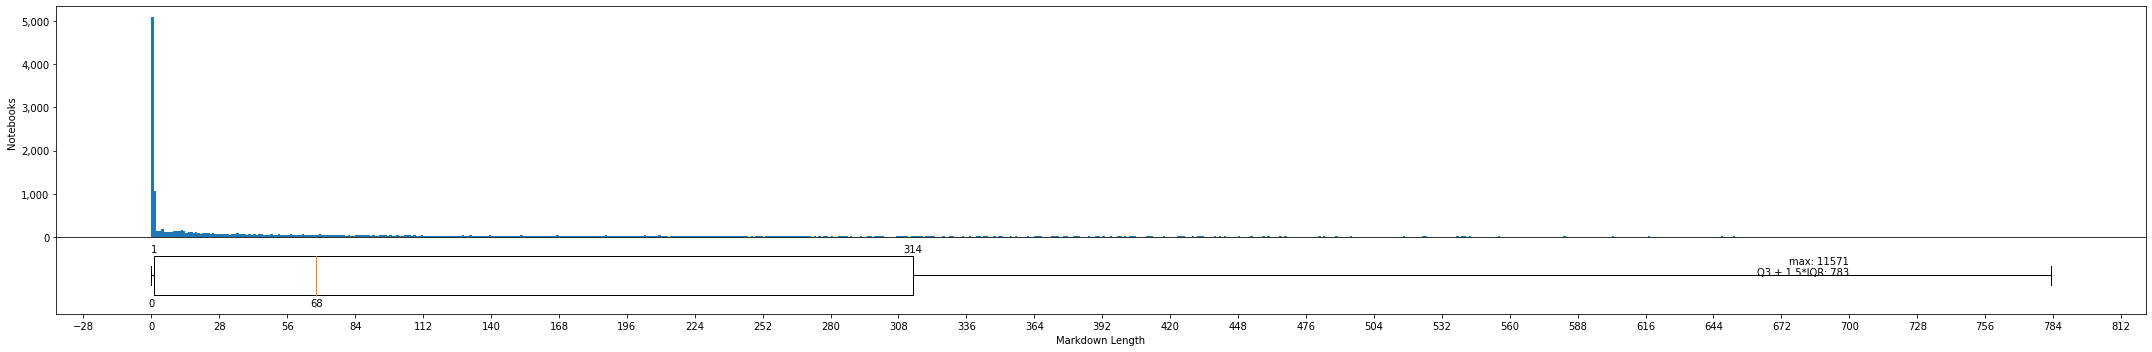

68


In [29]:
@calculate_auto(CONFIG)
@close_fig
def fn(notebooks, prefix):
    column = notebooks["p_words"]
    distribution = distribution_with_boxplot(
        column, 0, 700, 28, "Notebooks", "Markdown Length", True
    )
    print(distribution)
    return var(prefix + "markdown_p_words_median", int(distribution.median))